In [1]:
import os, sys, math, random, argparse
import numpy as np
import matplotlib.pyplot as plt

path = os.getcwd()
random.seed(100)

In [8]:
np.load('/data/HiHiC-main/data_hicplus/train_KR_300/train_ratio16.npz')['target'].shape


(37097, 1, 40, 40)

In [52]:
# 모델의 적합한 input이 모두 다르다

for input in os.listdir('/data/HiHiC-main'):
    if input.startswith('data_') and input.find(".") == -1:
        data_dir = input
        if 'test_KR_300' in os.listdir('/data/HiHiC-main/' + data_dir):
            print("\n", input)
            if os.listdir('/data/HiHiC-main/'+ input + '/test_KR_300/')[0].endswith(".npz"):
                print(np.load('/data/HiHiC-main/'+ input + '/test_KR_300/test_ratio16.npz').files)
                print(np.load('/data/HiHiC-main/'+ input + '/test_KR_300/test_ratio16.npz')['target'].shape)
            else:
                print(np.load('/data/HiHiC-main/'+ input + '/test_KR_300/test_ratio16.npy').shape)



 data_hicplus
['data', 'target', 'inds', 'inds_target']
(4081, 1, 40, 40)

 data_HiCNN
['data', 'target', 'inds', 'inds_target']
(4081, 1, 40, 40)

 data_DeepHiC
['data', 'target', 'inds', 'compacts', 'sizes']
(4081, 1, 40, 40)

 data_SRHiC
(4081, 40, 68)

 data_HiCARN
['data', 'target', 'inds', 'compacts', 'sizes']
(4081, 1, 40, 40)

 data_DFHiC
['data', 'target', 'inds', 'distance']
(4081, 40, 40, 1)


In [55]:
# 모델의 output 또한 모두 다르다

for out in os.listdir('/data/HiHiC-main/output_enhanced'):
    mat = np.load('/data/HiHiC-main/output_enhanced/' + out)
    print("\n",out)
    print(mat.files, mat['data'].shape)


 DeepHiC_predict_16_00042.npz
['data', 'inds'] (4081, 1, 40, 40)

 DFHiC_predict_16_00100.npz
['data', 'inds'] (4081, 40, 40, 1)

 HiCNN2_predict_16_00100.npz
['data', 'inds'] (4081, 1, 28, 28)

 SRHiC_predict_16_00089.npz
['data', 'inds'] (4081, 28, 28, 1)

 hicplus_predict_16_00100.npz
['data', 'inds'] (4081, 1, 28, 28)

 HiCARN_predict_16_00021.npz
['data', 'inds'] (4081, 1, 40, 40)


In [37]:
# 크로모좀 단위로 합쳐주기

def make_whole_40(predicted, save_filename):
    predicted = np.load(predicted, allow_pickle=True)
    mats = {}
    unique_chrom = np.unique(predicted['inds'][:, 0])
    for chrom in sorted(unique_chrom):
        chrom_indices = predicted['inds'][:, 0] == chrom
        mat_dim = predicted['inds'][chrom_indices][0, 1] + 1
        inds = predicted['inds'][chrom_indices][:, -2:] + [6, 6]
        submats = np.squeeze(predicted['data'])[chrom_indices, 6:34, 6:34]    
        mat = np.zeros((mat_dim, mat_dim))
        for ind, submat in zip(inds, submats):
            mat[ind[0]:ind[0]+28, ind[1]:ind[1]+28] = submat
        mats[str(chrom)] = np.triu(mat) + np.triu(mat, k=1).T # mats[str(chrom)] = mat
    np.savez_compressed(save_filename, **mats)
    
    
def make_whole_28(predicted, save_filename):
    predicted = np.load(predicted, allow_pickle=True)
    mats = {}
    unique_chrom = np.unique(predicted['inds'][:, 0])
    for chrom in sorted(unique_chrom):
        chrom_indices = predicted['inds'][:, 0] == chrom
        mat_dim = predicted['inds'][chrom_indices][0, 1] + 1
        inds = predicted['inds'][chrom_indices][:, -2:]
        submats = np.squeeze(predicted['data'])[chrom_indices, :, :]
        mat = np.zeros((mat_dim, mat_dim))
        for ind, submat in zip(inds, submats):
            mat[ind[0]:ind[0]+28, ind[1]:ind[1]+28] = submat
        mats[str(chrom)] = np.triu(mat) + np.triu(mat, k=1).T # mats[str(chrom)] = mat
    np.savez_compressed(save_filename, **mats)

In [3]:
os.makedirs('/data/HiHiC-main/output_chrom/', exist_ok=True)
for out in os.listdir('/data/HiHiC-main/output_enhanced'):
    mat = np.load('/data/HiHiC-main/output_enhanced/' + out)
    model = out.split('_')[0]
    
    if model == 'SRHiC':
        predicted = np.load('/data/HiHiC-main/output_enhanced/' + out, allow_pickle=True)
        index_file = os.path.join("/data/HiHiC-main/data_SRHiC/test_KR_300/index_test_ratio16.npz")
        index = np.load(index_file, allow_pickle=True)['inds_target']
        mats = {}
        unique_chrom = np.unique(index[:, 0])
        for chrom in sorted(unique_chrom):
            chrom_indices = index[:, 0] == chrom
            mat_dim = index[chrom_indices][0, 1] + 1
            inds = index[chrom_indices][:, -2:]
            submats = np.squeeze(predicted['data'])[chrom_indices, :, :]
            mat = np.zeros((mat_dim, mat_dim))
            for ind, submat in zip(inds, submats):
                mat[ind[0]:ind[0]+28, ind[1]:ind[1]+28] = submat
            mats[str(chrom)] = np.triu(mat) + np.triu(mat, k=1).T # mats[str(chrom)] = mat
        np.savez_compressed('/data/HiHiC-main/output_chrom/' + model + '.npz', **mats)
    
    elif np.squeeze(mat['data']).shape[-1] == 40:
        make_whole_40('/data/HiHiC-main/output_enhanced/' + out, '/data/HiHiC-main/output_chrom/' + model + '.npz')
        
    else:      
        make_whole_28('/data/HiHiC-main/output_enhanced/' + out, '/data/HiHiC-main/output_chrom/' + model + '.npz')

In [6]:
sorted(os.listdir("/data/HiHiC-main/log_KR_300/"))

['train_loss_DFHiC.npy',
 'train_loss_DeepHiC.npy',
 'train_loss_HiCARN2.npy',
 'train_loss_HiCNN2.npy',
 'train_loss_SRHiC.npy',
 'train_loss_hicplus.npy',
 'train_loss_hicplus_100.npy',
 'train_loss_iEnhance.npy']

In [12]:
np.load("/data/HiHiC-main/log_KR_300/"+'train_loss_SRHiC.npy')

array([['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
        '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
        '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
        '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45',
        '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56',
        '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67',
        '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78',
        '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89',
        '90', '91', '92', '93', '94', '95', '96', '97', '98', '99',
        '100'],
       ['0.00.16', '0.00.22', '0.00.29', '0.00.35', '0.00.41', '0.00.48',
        '0.00.54', '0.01.00', '0.01.07', '0.01.13', '0.01.20', '0.01.26',
        '0.01.32', '0.01.39', '0.01.45', '0.01.51', '0.01.58', '0.02.04',
        '0.02.11', '0.02.17', '0.02.23', '0.02.31', '0.02.37', '0.02.44',
        '0.02.50', '0.02.57', '

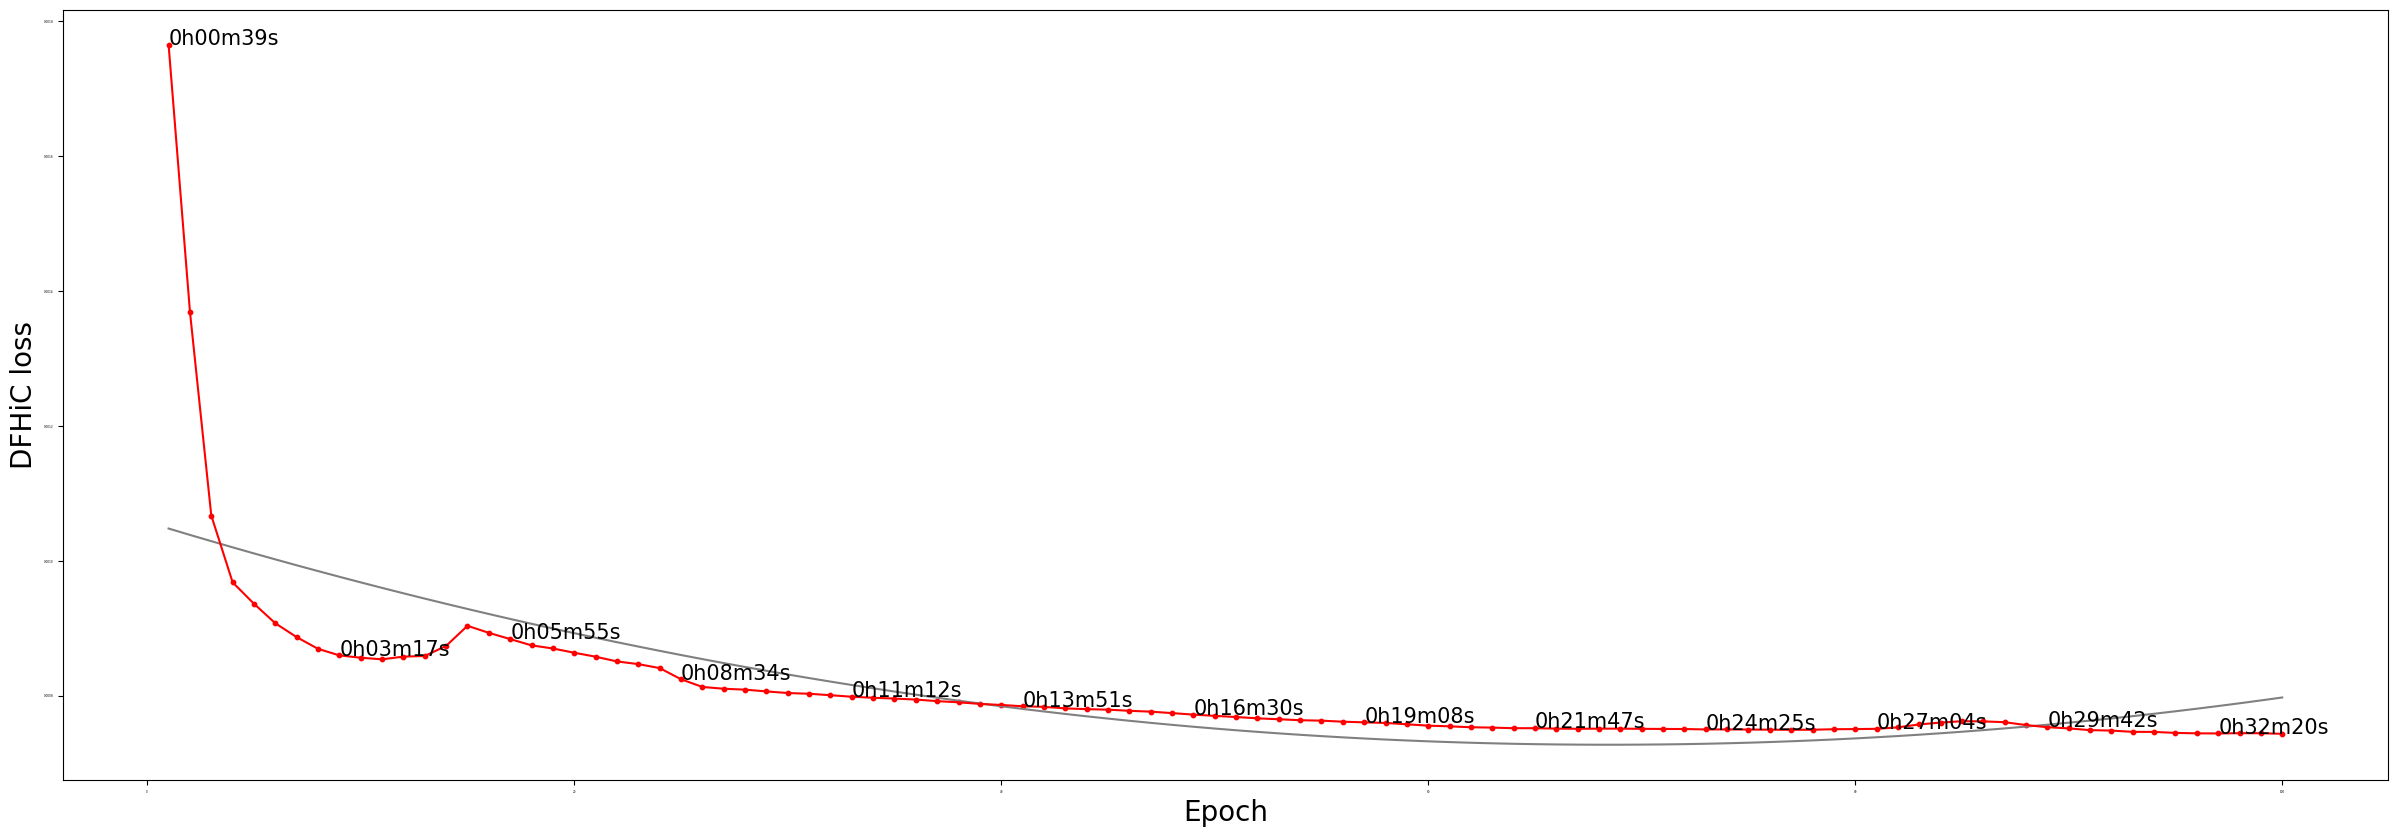

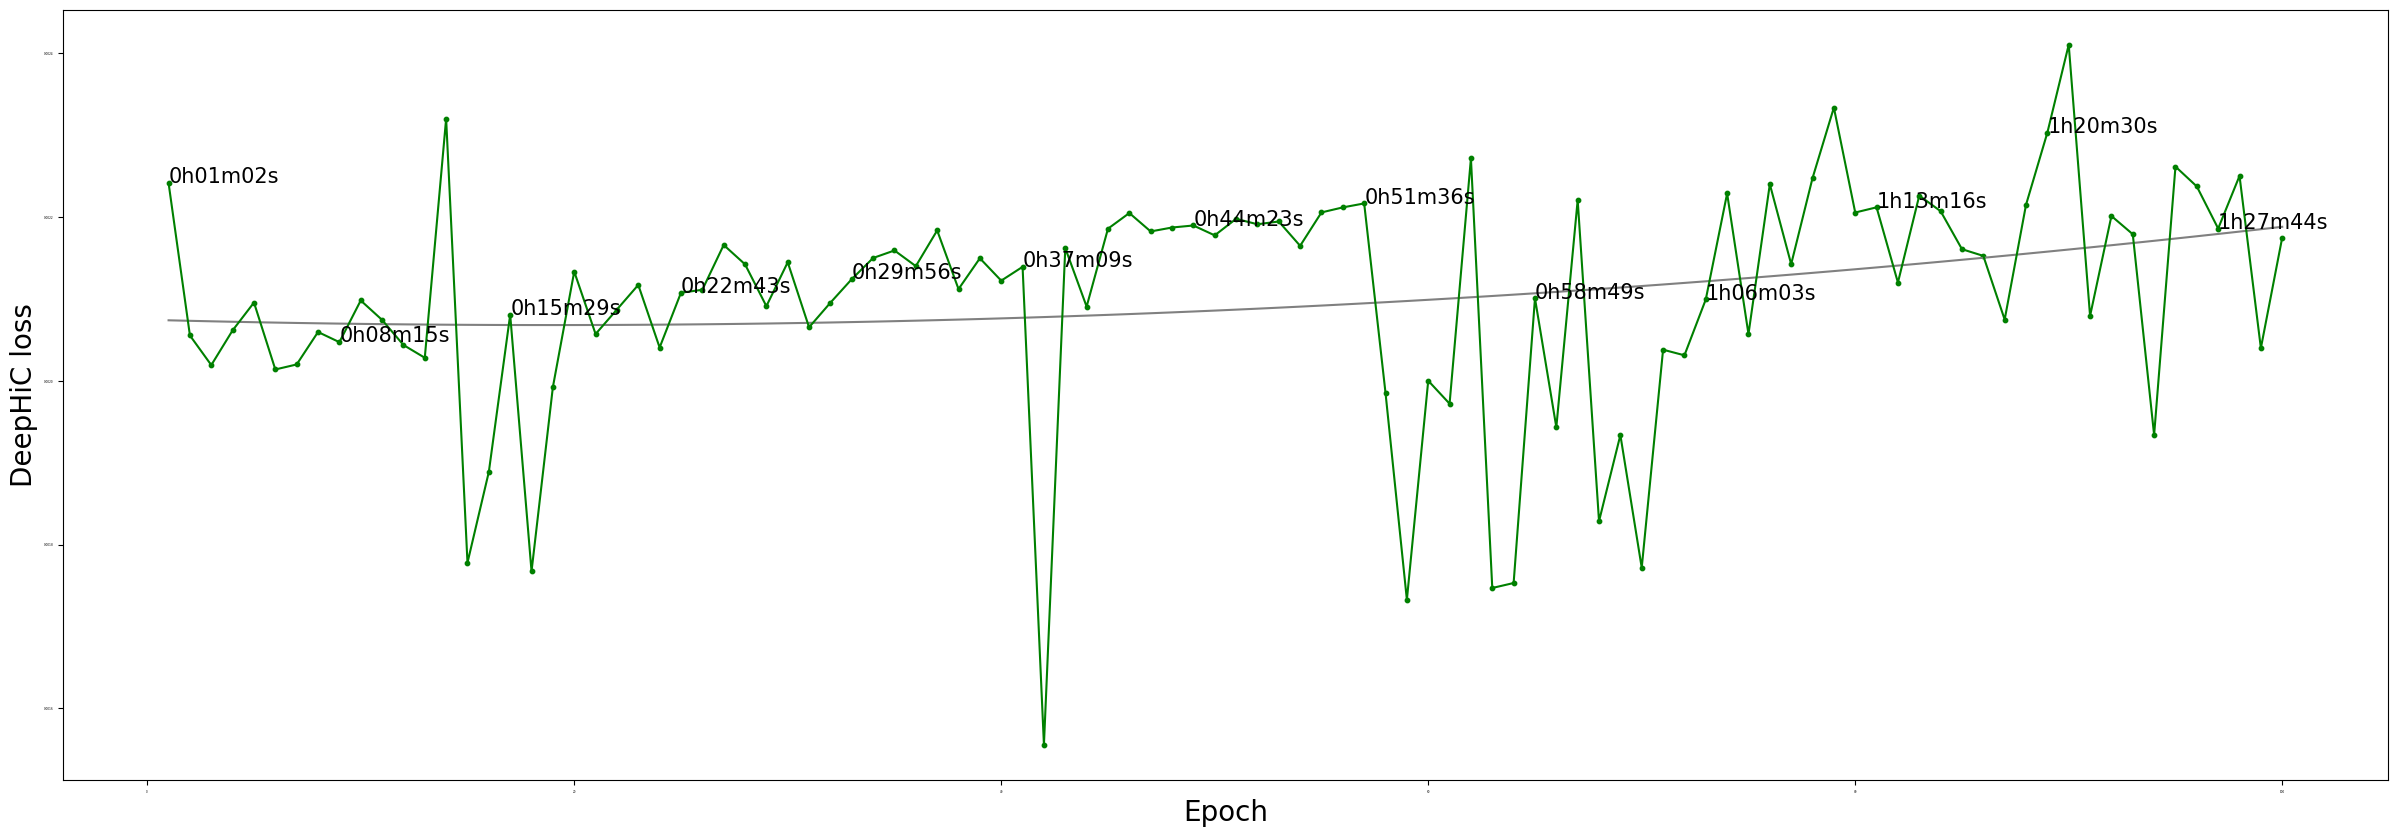

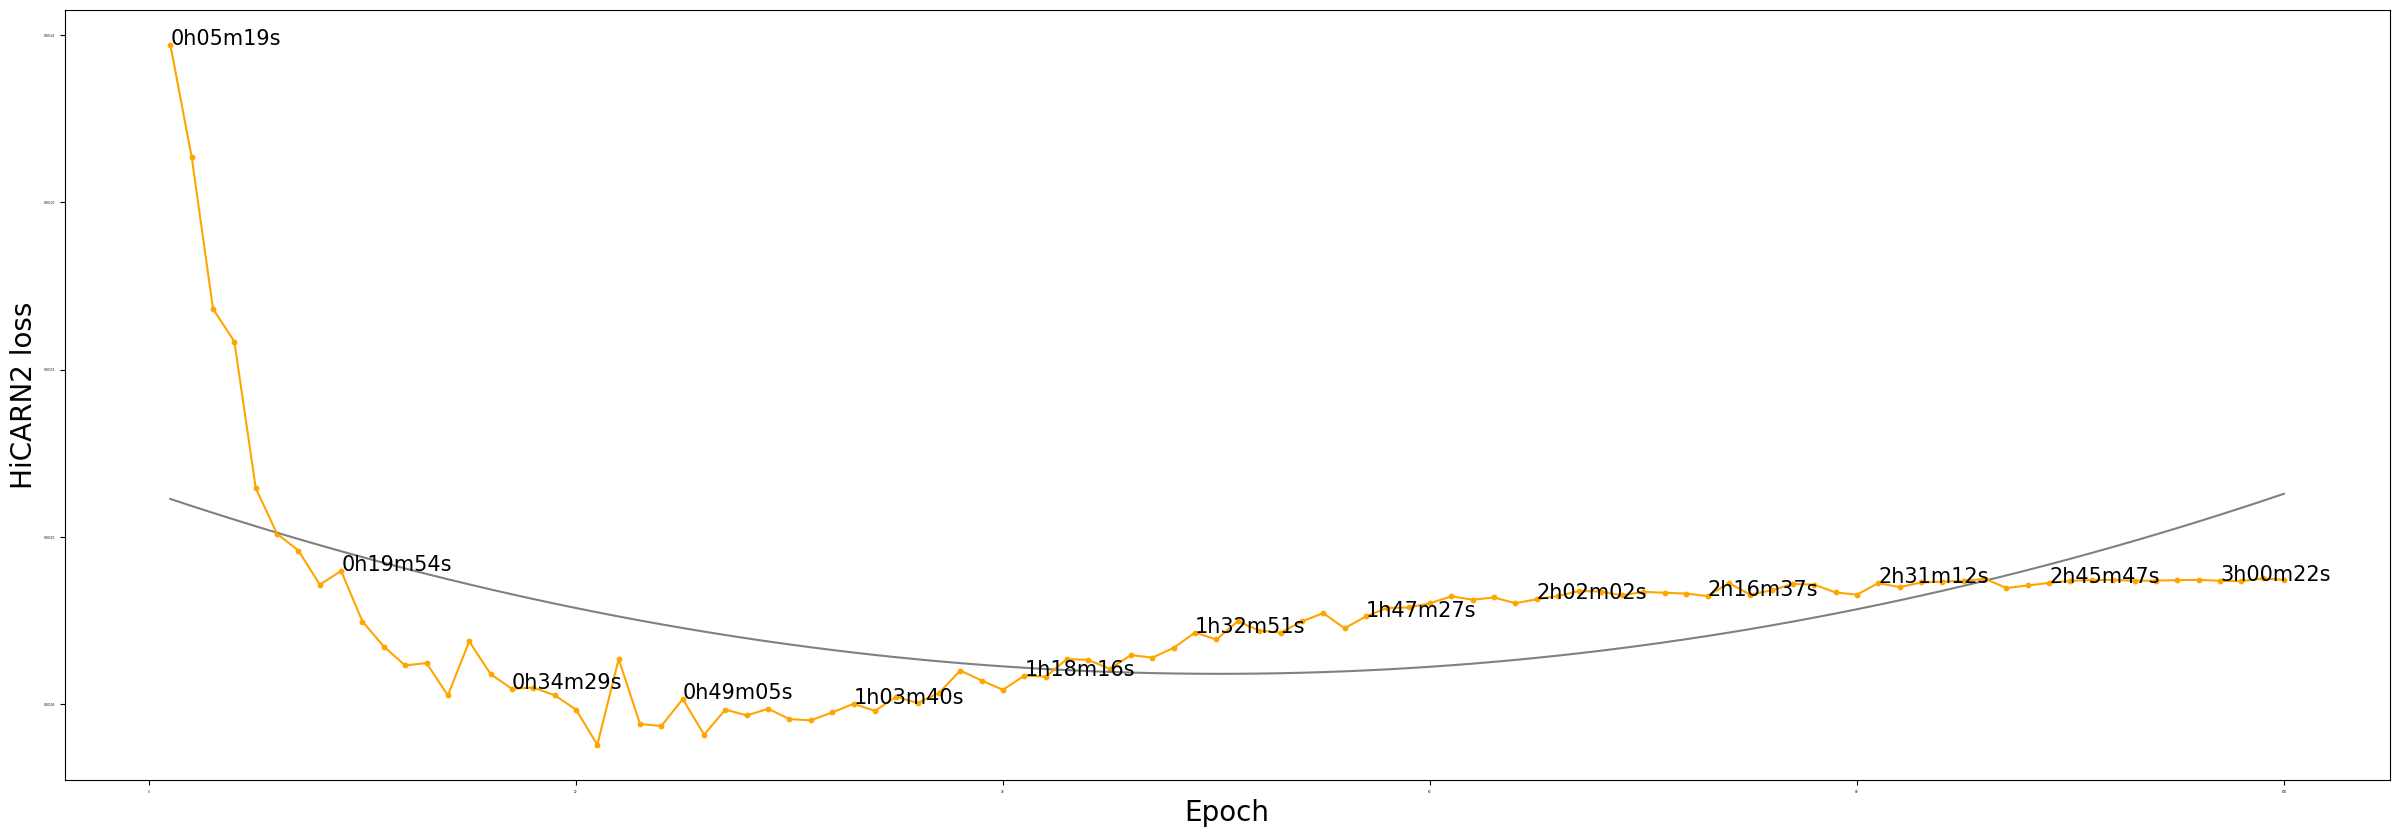

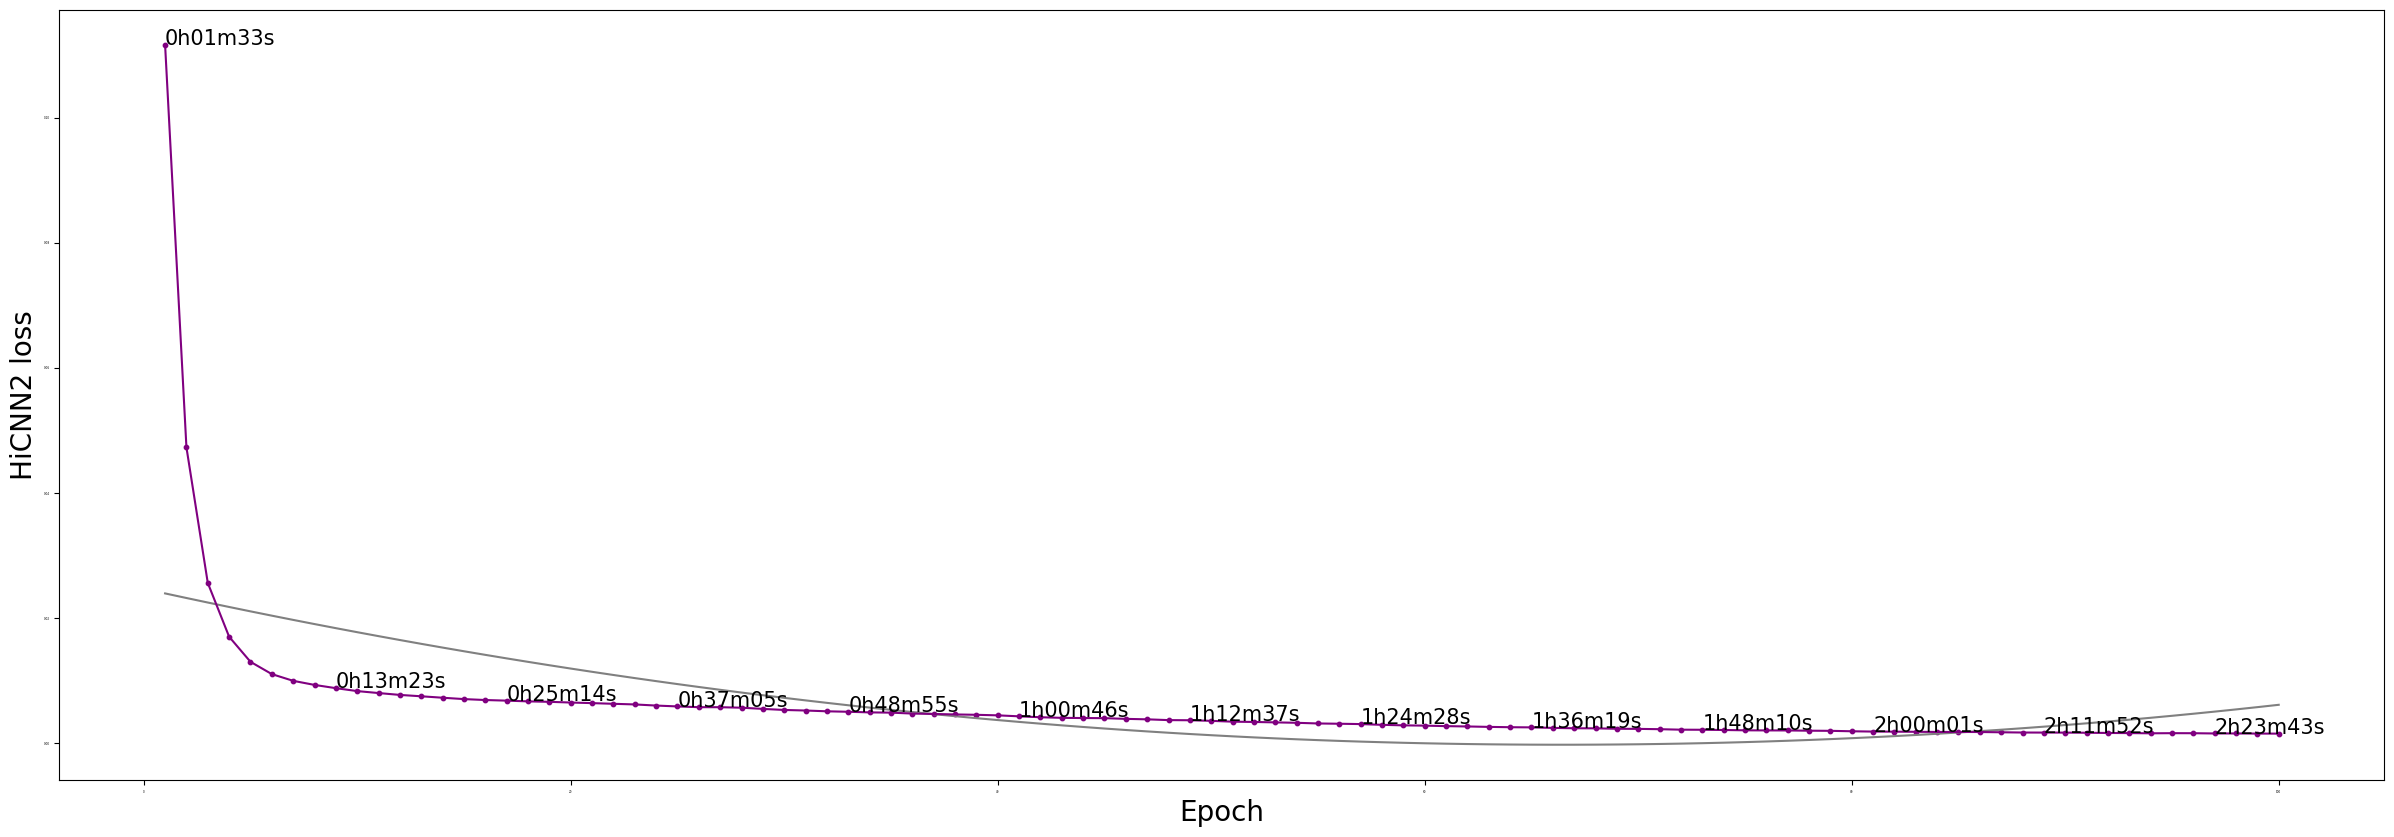

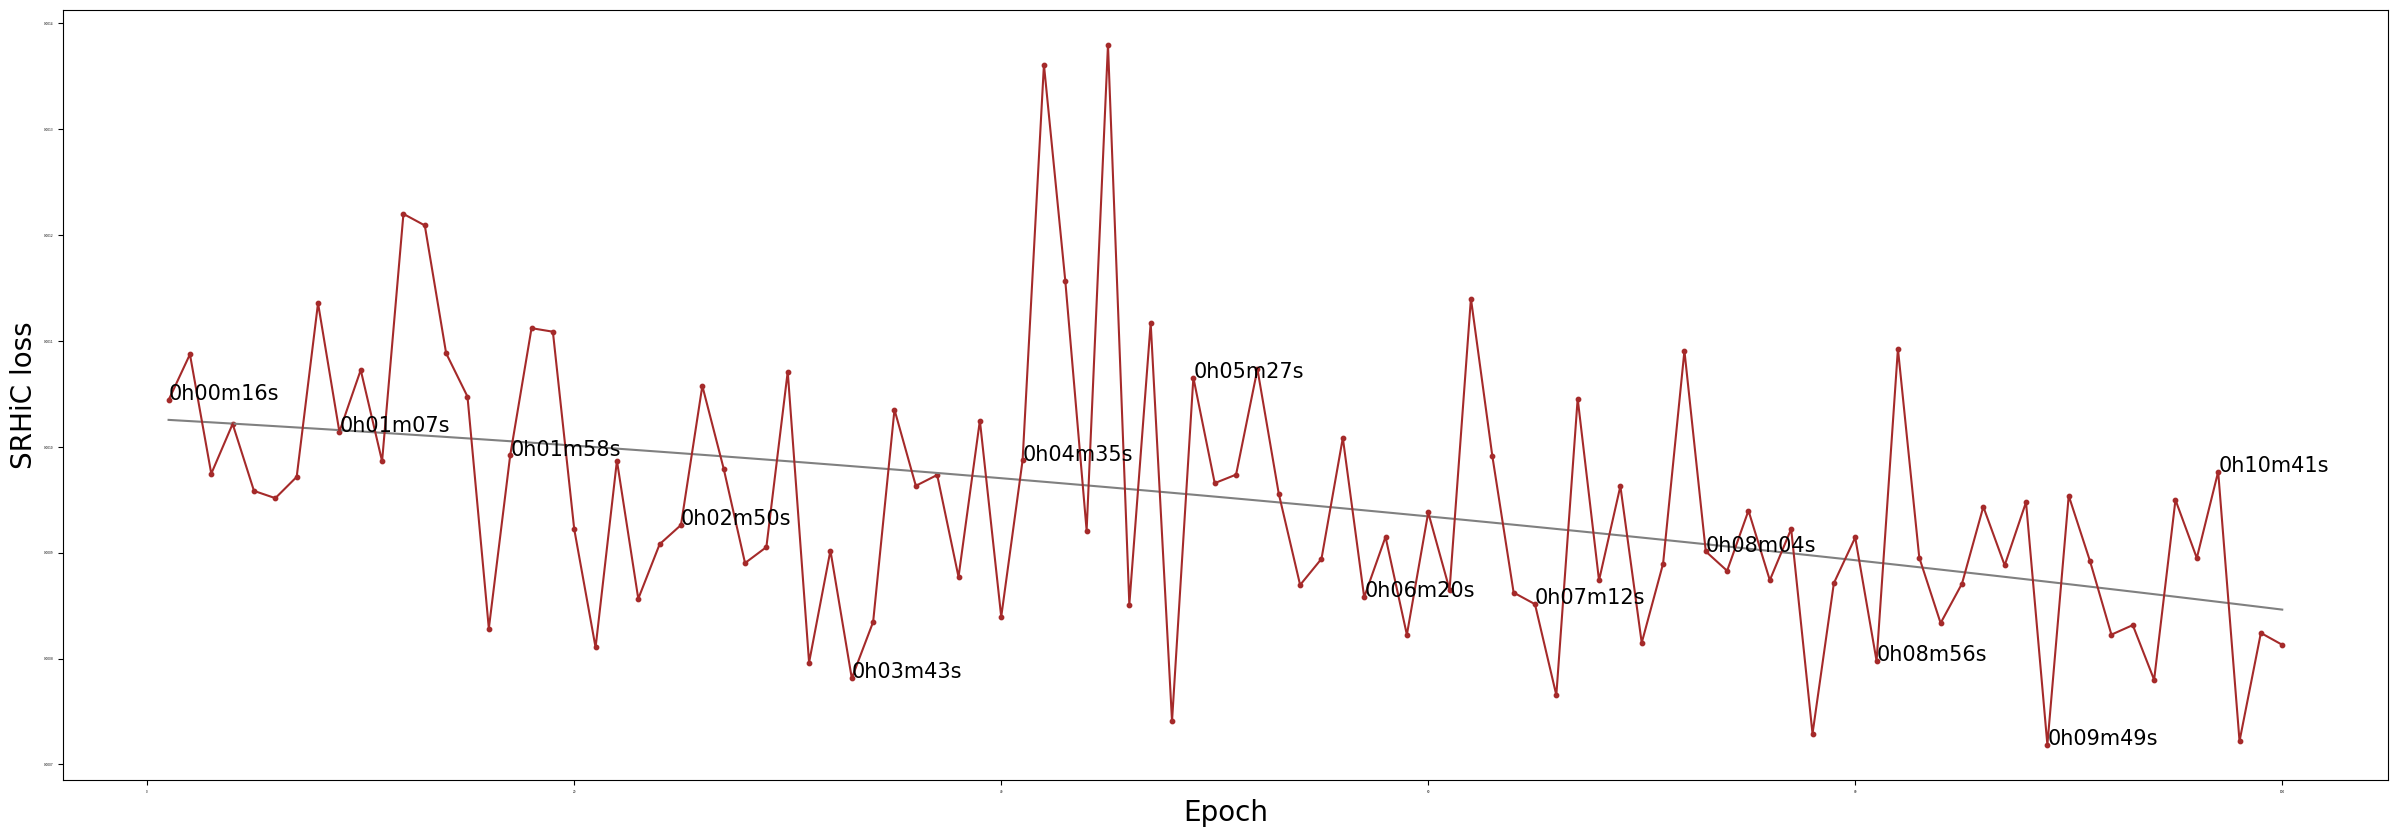

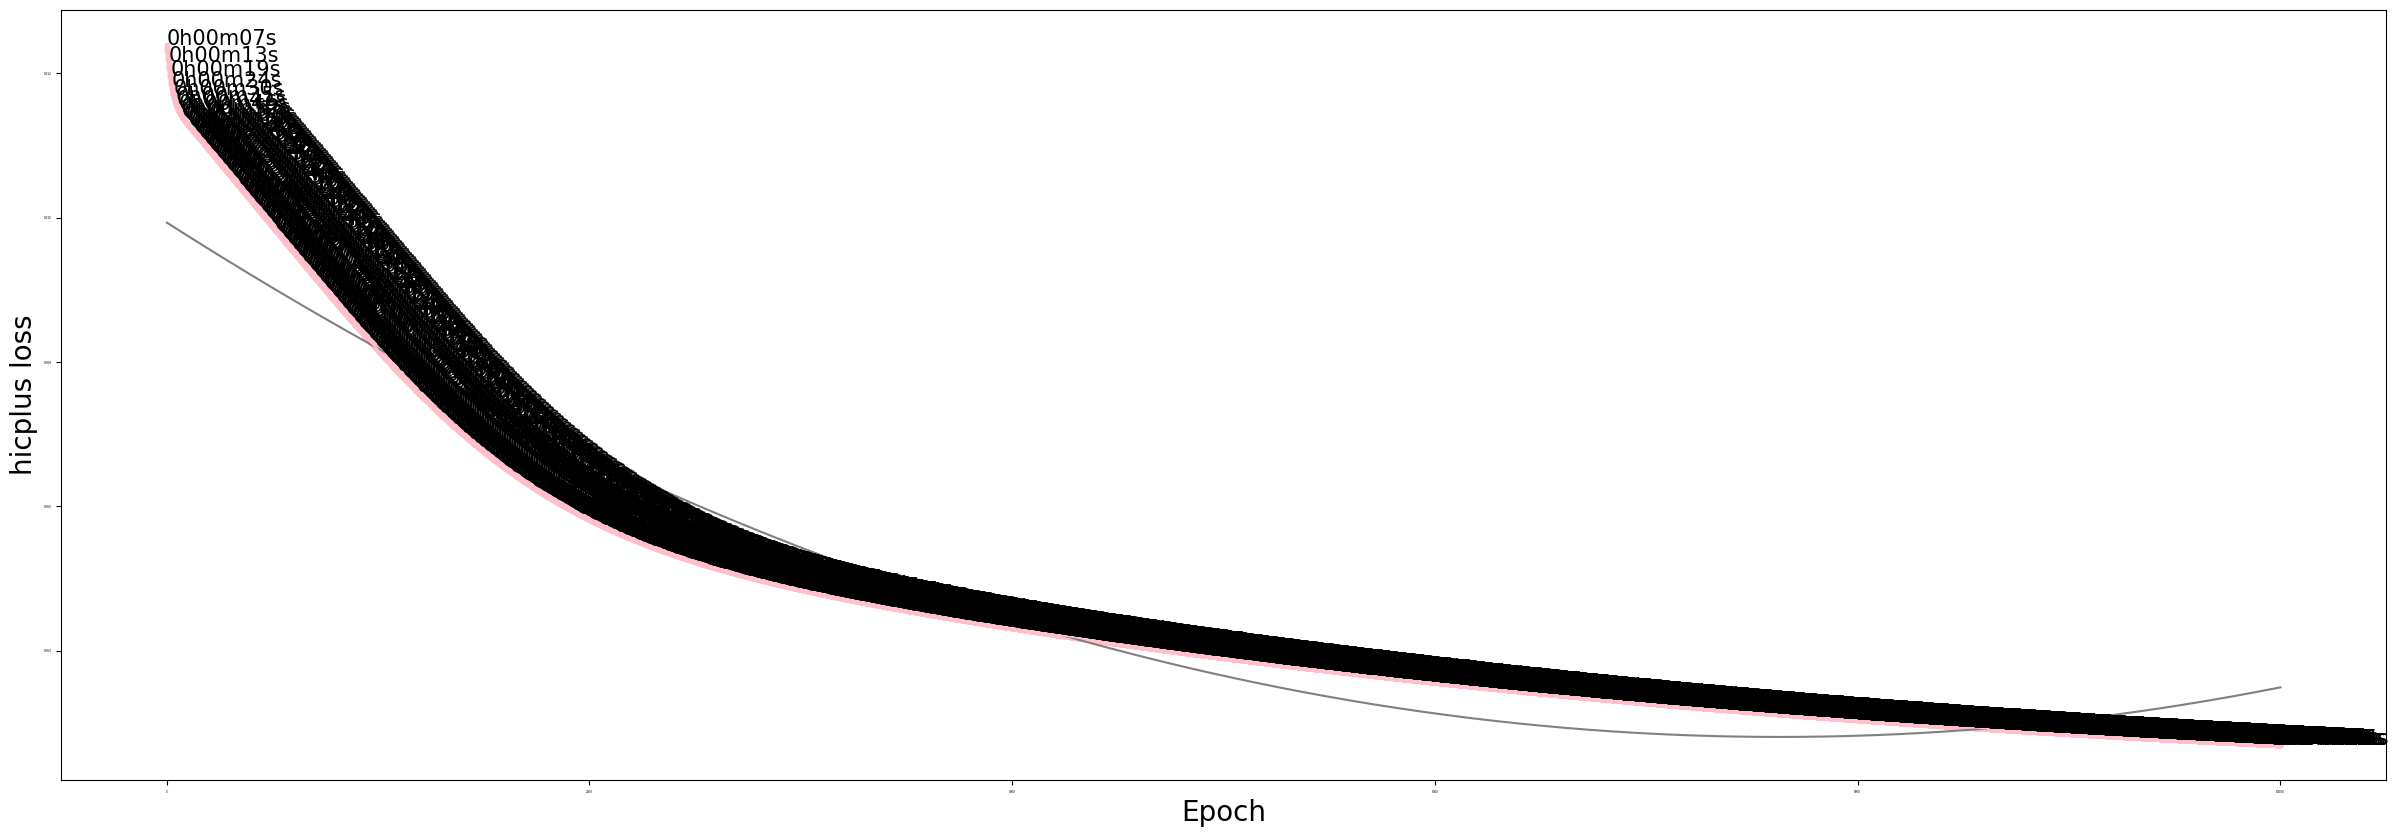

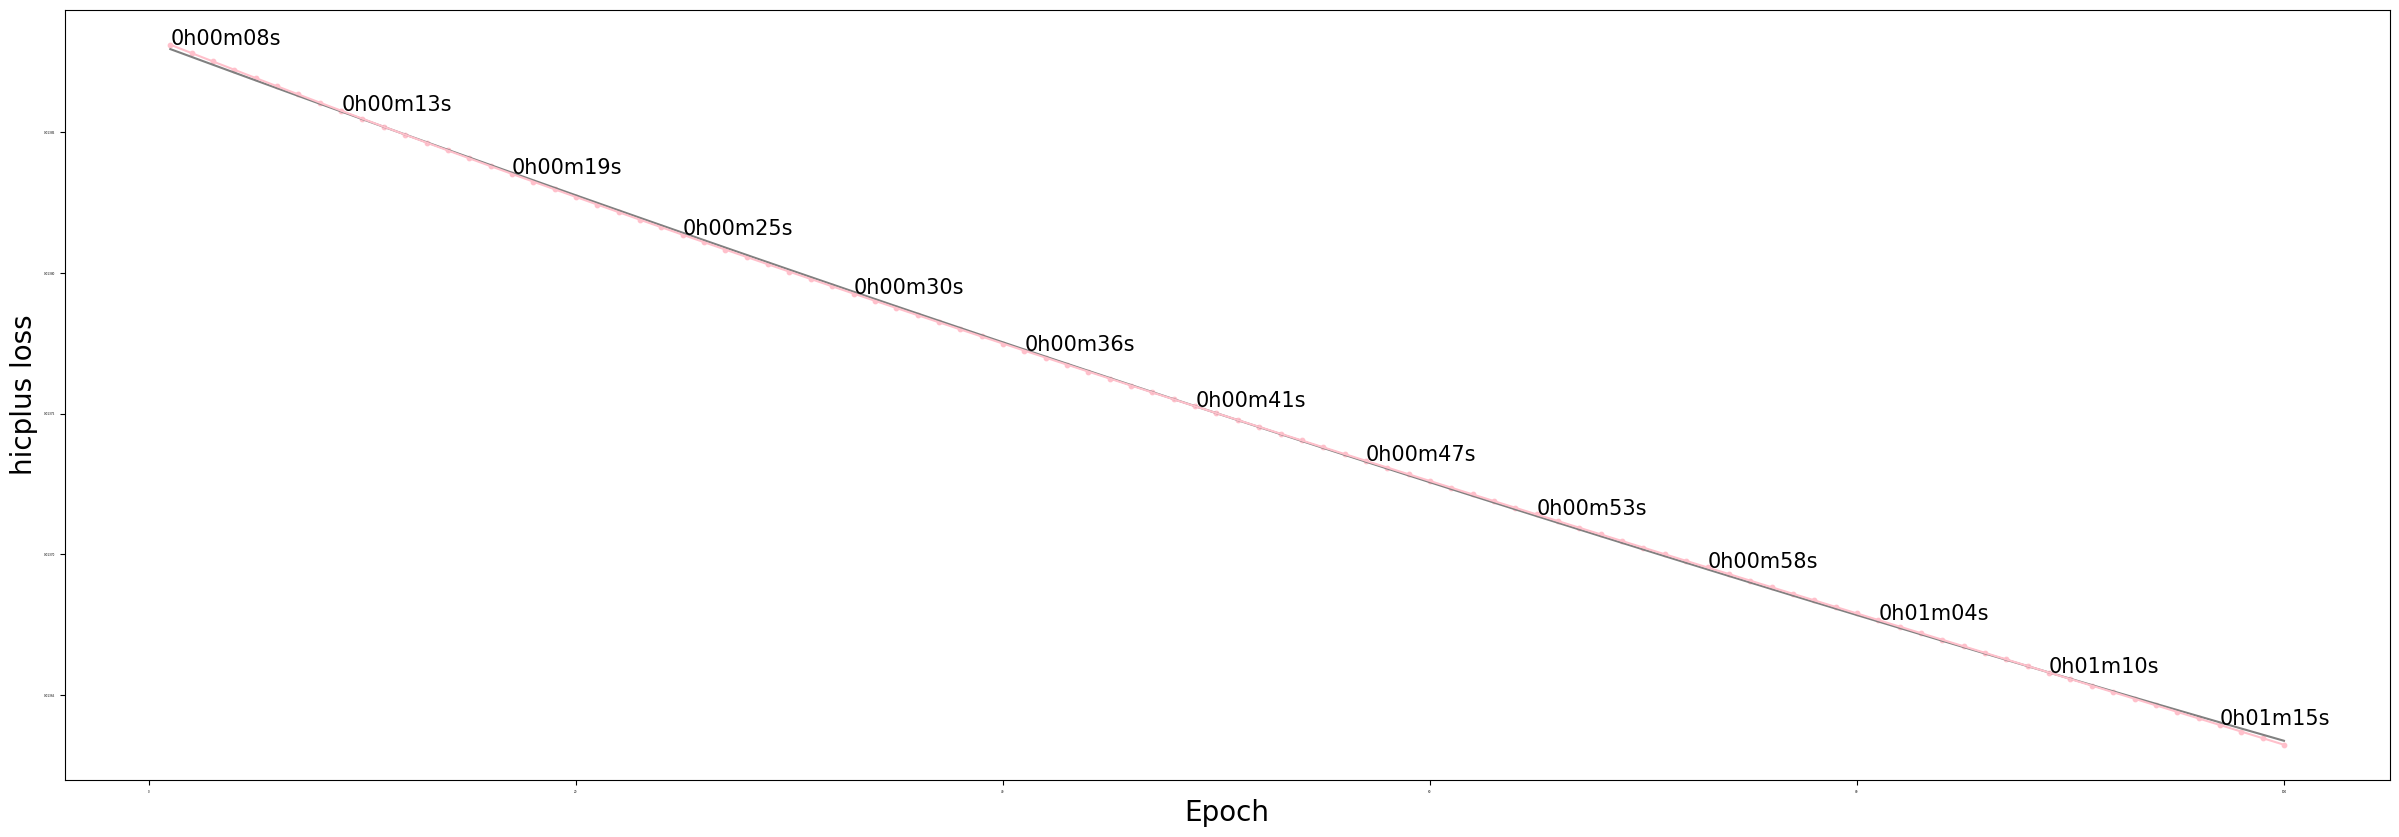

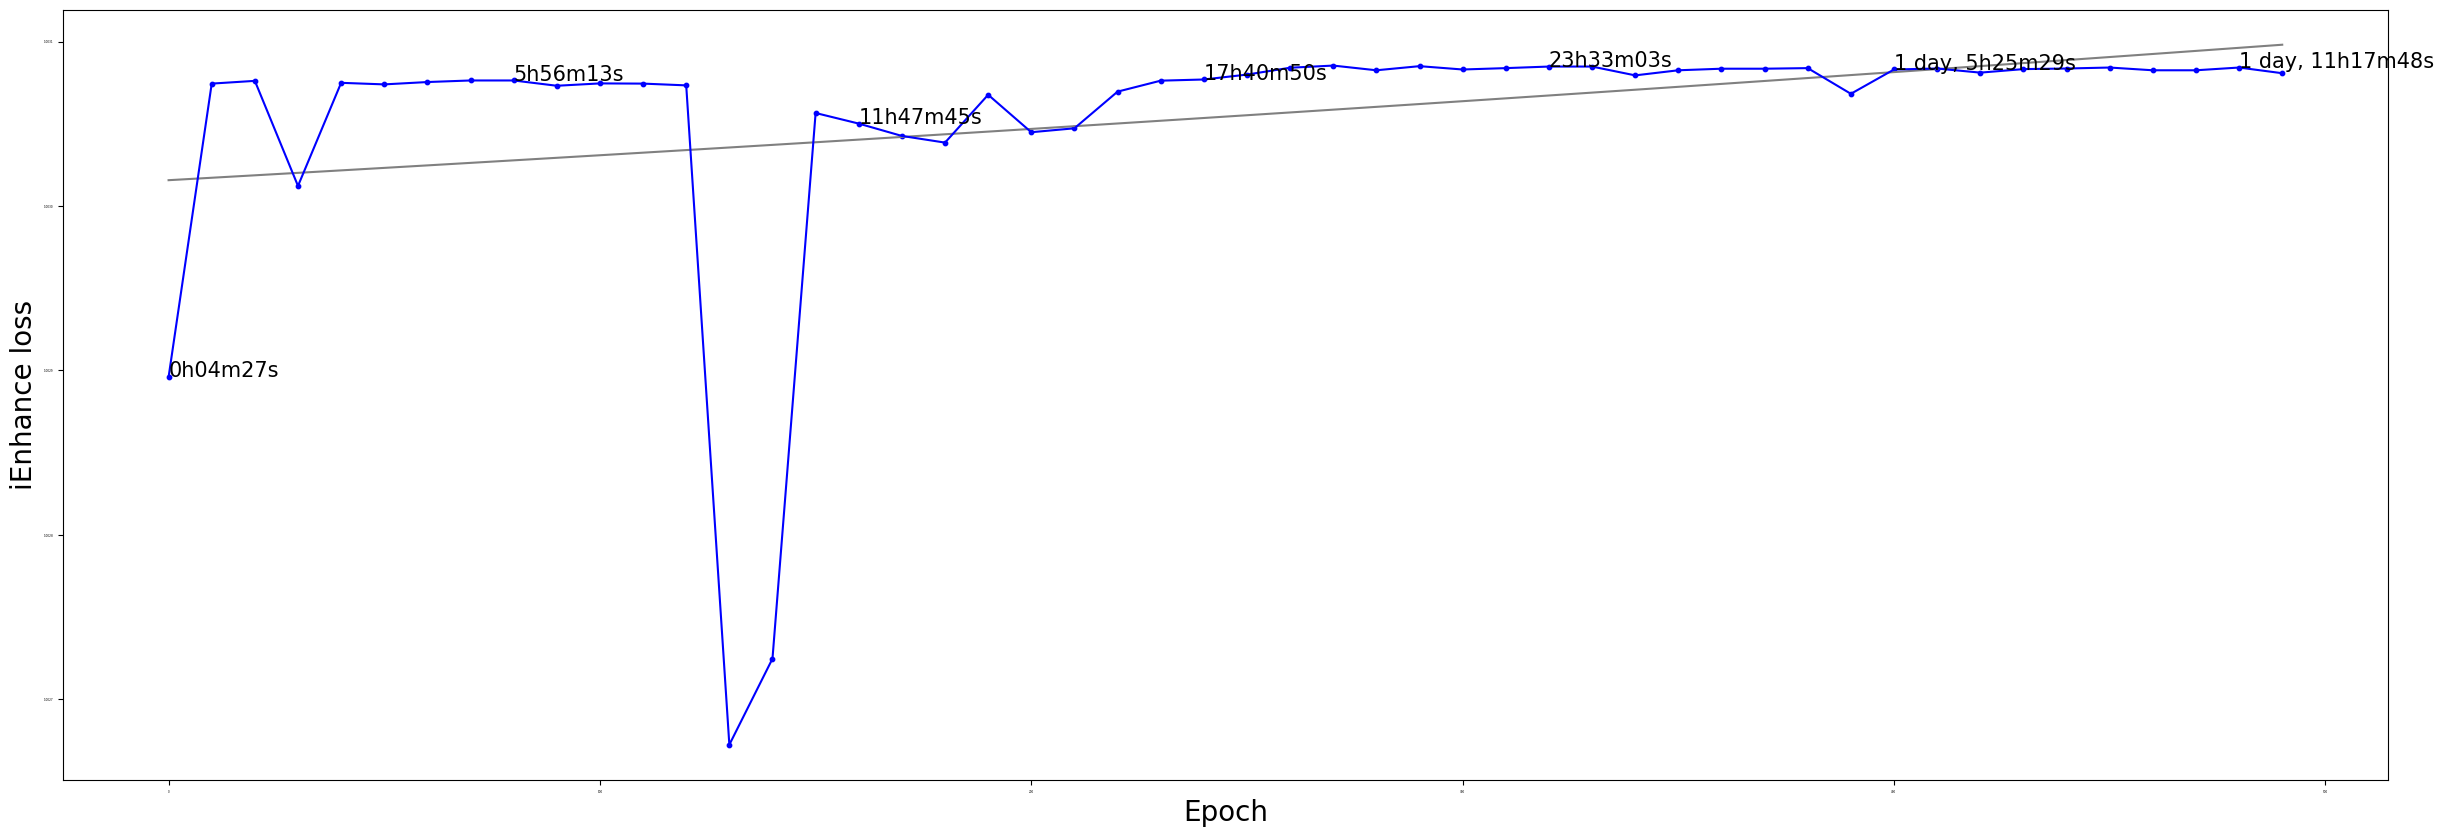

In [10]:
# loss

plt.rcParams.update({'font.size': 2})

for i, c in zip(sorted(os.listdir("/data/HiHiC-main/log_KR_300/")),
                ['red', 'green', 'orange', 'purple', 'brown','pink', 'pink', 'blue']):
    model=i.split("_")[2].split(".")[0]
    plt.figure(figsize=(30,10))
    i = np.load("/data/HiHiC-main/log_KR_300/" + i)
    x = i[0].astype(np.int32)
    y = i[2].astype(np.float32)
    plt.scatter(x,y, s=10, c=c)
    z = np.polyfit(x,y, 2)
    p = np.poly1d(z)
    plt.plot(x, p(x), color='gray')
    plt.plot(x, y, color=c, label=model)
    for i, (xx, yy, time) in enumerate(zip(x, y, i[1])):
        if i%8 ==0:
            plt.text(xx, yy, time.replace('.','h', 1).replace('.', 'm', 1)+'s', fontsize="15")
    # plt.ylim([0.39, 0.42]) # [0.39, 0.42]
    plt.xlabel("Epoch", fontsize="20")
    plt.ylabel(model+" loss", fontsize="20")
    # plt.legend(fontsize="20")
    # plt.savefig('loss_trend.png')
    plt.show()

In [13]:
np.load("/data/HiHiC-main/data_SRHiC/train/train_ratio16.npy")

array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  3.,  0.,  1.],
        [ 0.,  0.,  0., ...,  0.,  0.,  3.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 3.,  2.,  2., ...,  0.,  0.,  0.],
        [ 2.,  0.,  1., ...,  0.,  0.,  0.],
        [ 2.,  1.,  3., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 2.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       ...,

       [[ 0.,  0.,  0., ...,  1.,  1.,  1.],
        [ 0.,  0.,  0., ...,  1.,  1.,  3.],
        [ 0.,  0.,  0., ...,  1.,  2.,  3.

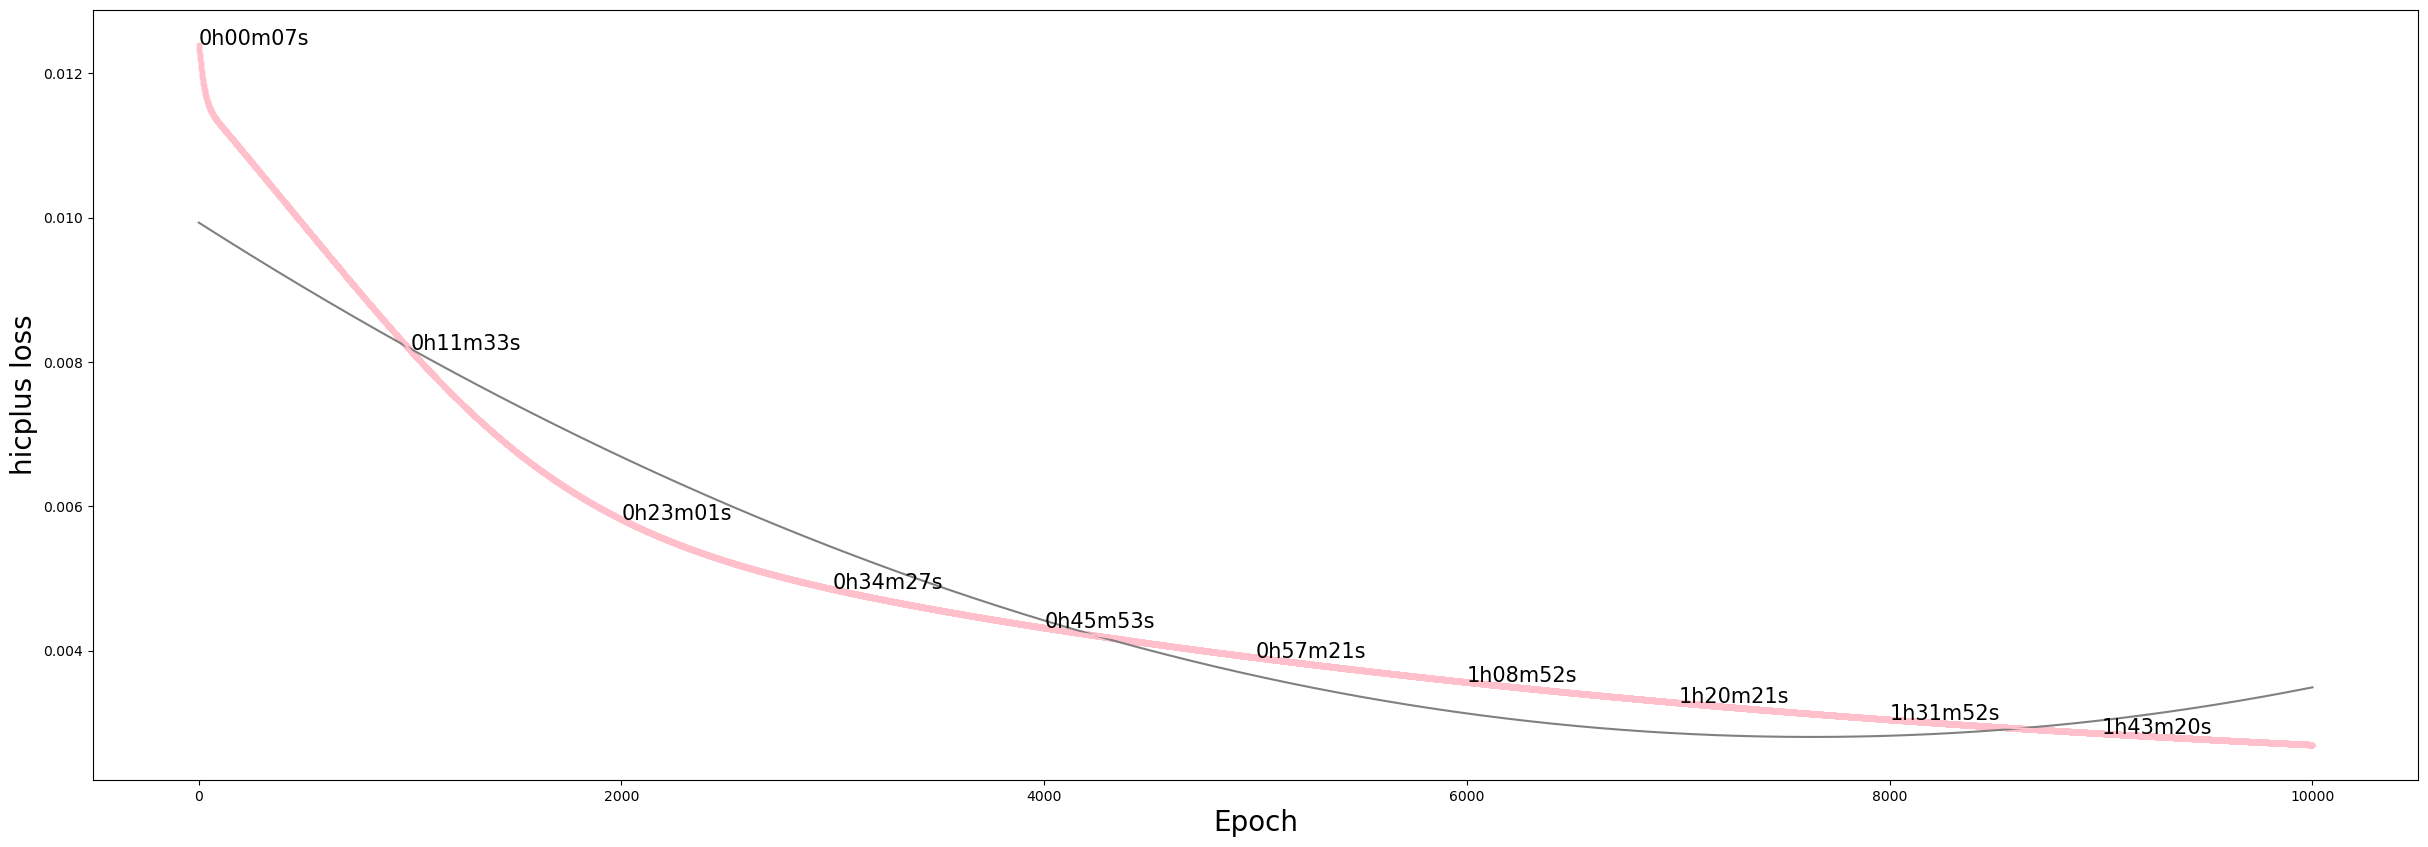

In [9]:
plt.rcParams.update({'font.size': 10})

# i = 'train_loss_hicplus.npy'
c = 'pink'

model='hicplus'
plt.figure(figsize=(30,10))
i = np.load("/data/HiHiC-main/log_KR_300/train_loss_hicplus.npy")
x = i[0][:10000].astype(np.int32)
y = i[2][:10000].astype(np.float32)
plt.scatter(x,y, s=10, c=c)
z = np.polyfit(x,y, 2)
p = np.poly1d(z)
plt.plot(x, p(x), color='gray')
plt.plot(x, y, color=c, label=model)
for i, (xx, yy, time) in enumerate(zip(x, y, i[1][:10000])):
    if i%1000 ==0:
        plt.text(xx, yy, time.replace('.','h', 1).replace('.', 'm', 1)+'s', fontsize="15")
# plt.ylim([0.39, 0.42]) # [0.39, 0.42]
plt.xlabel("Epoch", fontsize="20")
plt.ylabel(model+" loss", fontsize="20")
# plt.legend(fontsize="20")
# plt.savefig('loss_trend.png')
plt.show()

In [12]:
# x = np.load("/data/HiHiC-main/data_hicplus/test/test_ratio16.npz")

# predicted = "/data/HiHiC-main/data_hicplus/test/test_ratio16.npz"
# save_filename = '/data/HiHiC-main/output_chrom/data_hicplus.npz'

# predicted = np.load(predicted, allow_pickle=True)
# mats = {}
# unique_chrom = np.unique(predicted['inds'][:, 0])
# for chrom in sorted(unique_chrom):
#     chrom_indices = predicted['inds'][:, 0] == chrom
#     mat_dim = predicted['inds'][chrom_indices][0, 1] + 1
#     inds = predicted['inds'][chrom_indices][:, -2:] + [6, 6]
#     submats = np.squeeze(predicted['data'])[chrom_indices, 6:34, 6:34]    
#     mat = np.zeros((mat_dim, mat_dim))
#     for ind, submat in zip(inds, submats):
#         mat[ind[0]:ind[0]+28, ind[1]:ind[1]+28] = submat
#     mats[str(chrom)] = np.triu(mat) + np.triu(mat, k=1).T # mats[str(chrom)] = mat
# np.savez_compressed(save_filename, **mats)

# file = np.load(save_filename)
# for chr in ['18','19','20','21','22']:
#     plt.imshow(file[chr][6:86, 6:86], cmap='hot')
#     plt.colorbar()
    # plt.show()

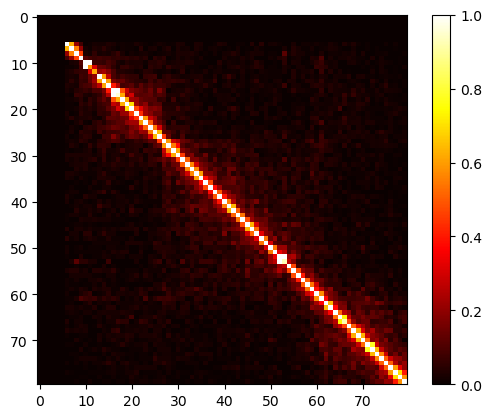

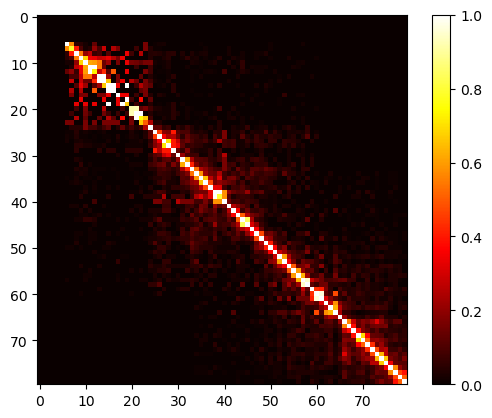

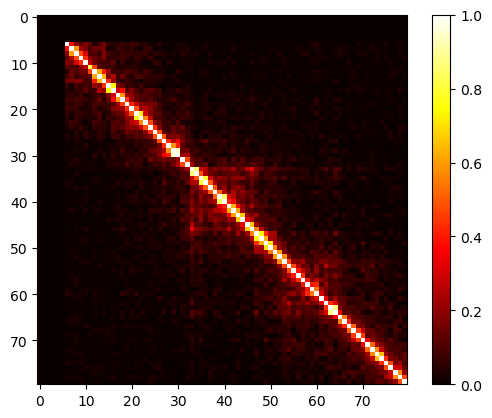

In [29]:
x = np.load("/data/HiHiC-main/data_HiCNN/test/test_ratio16.npz")

predicted = "/data/HiHiC-main/data_HiCNN/test_KR_300/test_ratio16.npz"
save_filename = '/data/HiHiC-main/output_chrom/target.npz'

# predicted = np.load(predicted, allow_pickle=True)
# mats = {}
# unique_chrom = np.unique(predicted['inds'][:, 0])
# for chrom in sorted(unique_chrom):
#     chrom_indices = predicted['inds'][:, 0] == chrom
#     mat_dim = predicted['inds'][chrom_indices][0, 1] + 1
#     inds = predicted['inds'][chrom_indices][:, -2:] + [6, 6]
#     submats = np.squeeze(predicted['target'])[chrom_indices, 6:34, 6:34]    
#     mat = np.zeros((mat_dim, mat_dim))
#     for ind, submat in zip(inds, submats):
#         mat[ind[0]:ind[0]+28, ind[1]:ind[1]+28] = submat
#     mats[str(chrom)] = np.triu(mat) + np.triu(mat, k=1).T # mats[str(chrom)] = mat
# np.savez_compressed(save_filename, **mats)

file = np.load(save_filename)
for chr in ['18','19','20']:
    plt.imshow(file[chr][0:80, 0:80], cmap='hot')
    plt.colorbar()
    plt.show()

HiCNN2.npz
True
18
(7809, 7809) 



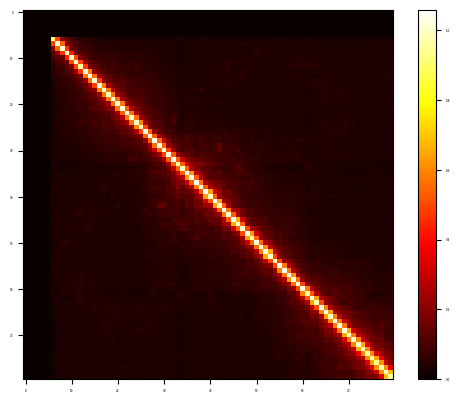

True
19
(5914, 5914) 



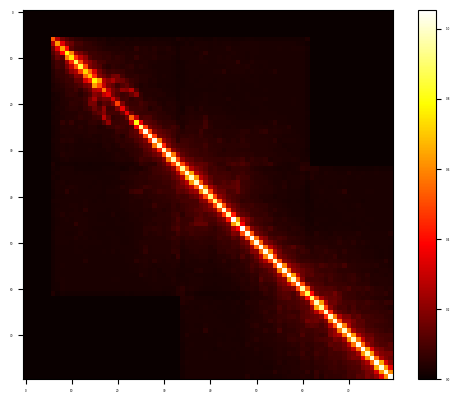

True
20
(6304, 6304) 



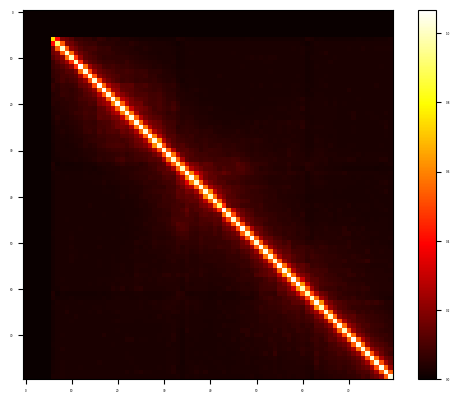

SRHiC.npz
True
18
(7809, 7809) 



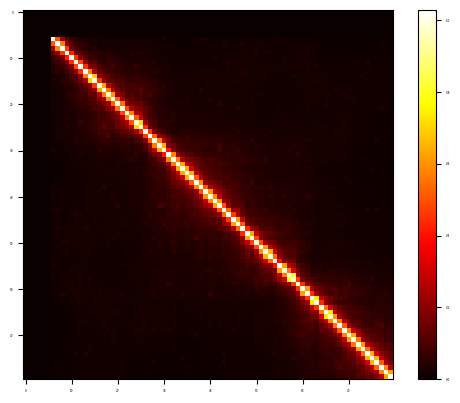

True
19
(5914, 5914) 



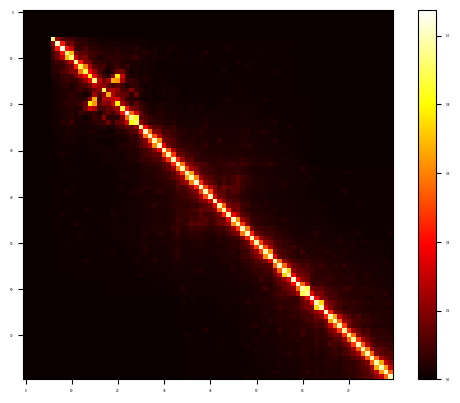

True
20
(6304, 6304) 



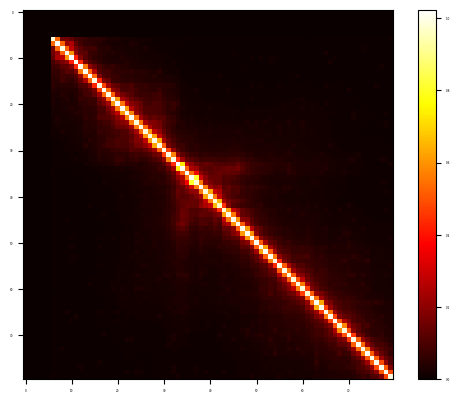

HiCARN.npz
True
18
(7809, 7809) 



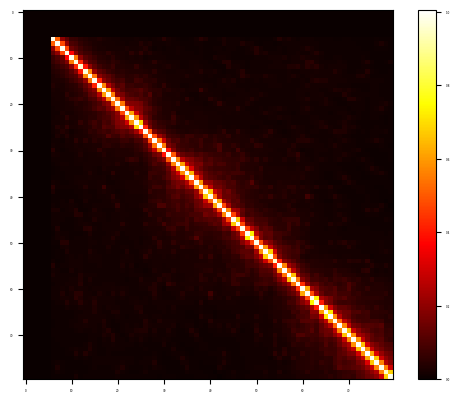

True
19
(5914, 5914) 



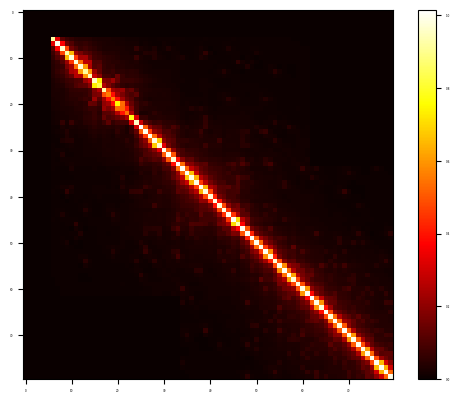

True
20
(6304, 6304) 



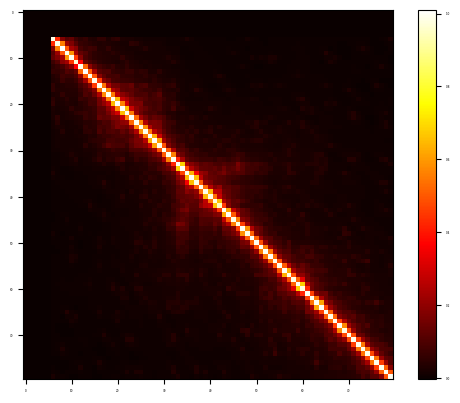

hicplus.npz
True
18
(7809, 7809) 



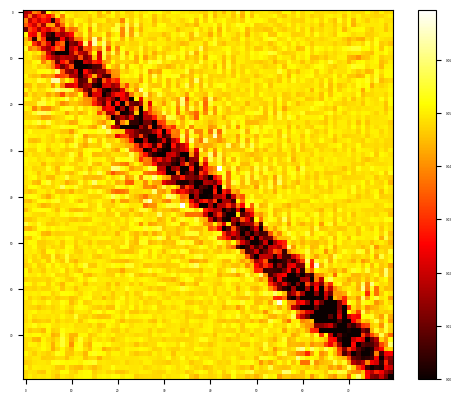

True
19
(5914, 5914) 



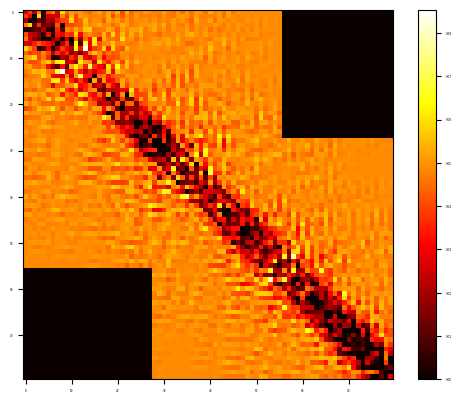

True
20
(6304, 6304) 



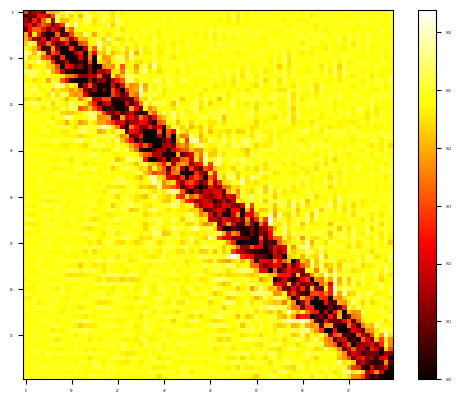

DFHiC.npz
True
18
(7809, 7809) 



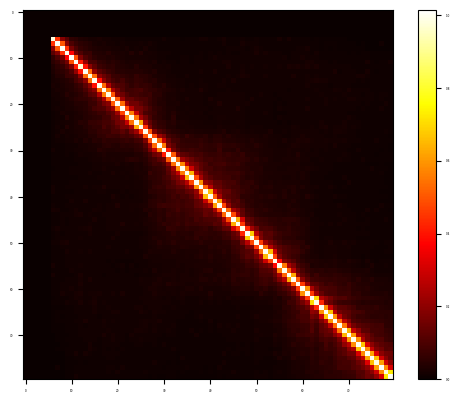

True
19
(5914, 5914) 



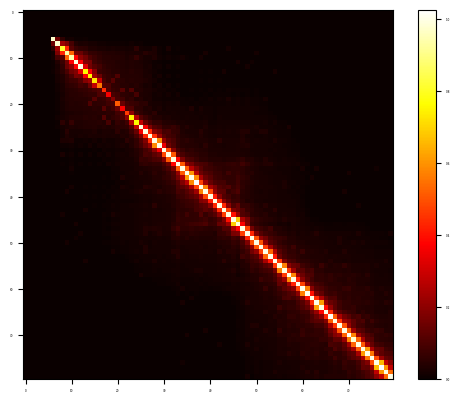

True
20
(6304, 6304) 



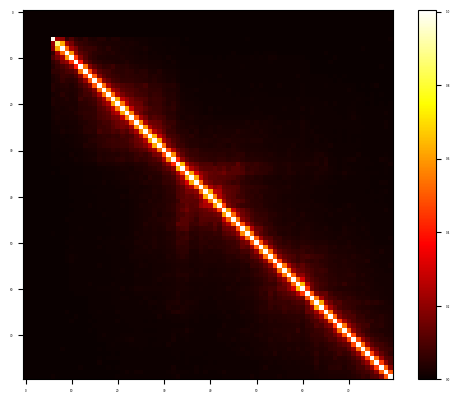

DeepHiC.npz
True
18
(7809, 7809) 



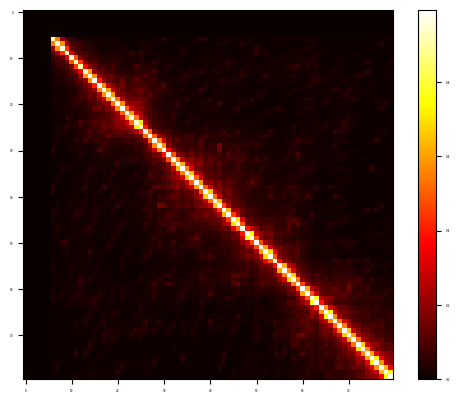

True
19
(5914, 5914) 



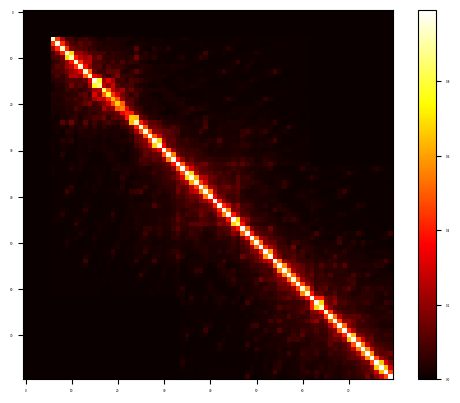

True
20
(6304, 6304) 



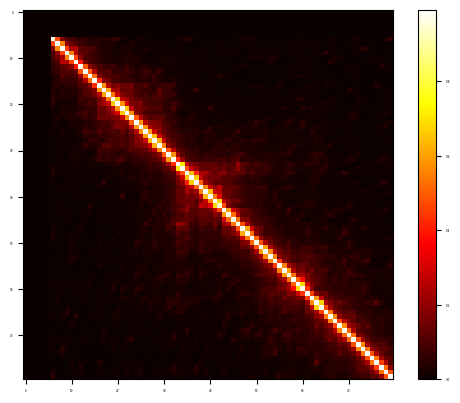

In [75]:
for out in os.listdir("/data/HiHiC-main/output_chrom"):
    print(out)
    file = np.load("/data/HiHiC-main/output_chrom/"+out)
    for chr in ['18','19','20']:
        print(np.allclose(file[chr], file[chr].T))
        print(chr)
        print(file[chr].shape, '\n')
        plt.imshow(file[chr][0:80, 0:80], cmap='hot')
        plt.colorbar()
        plt.show()

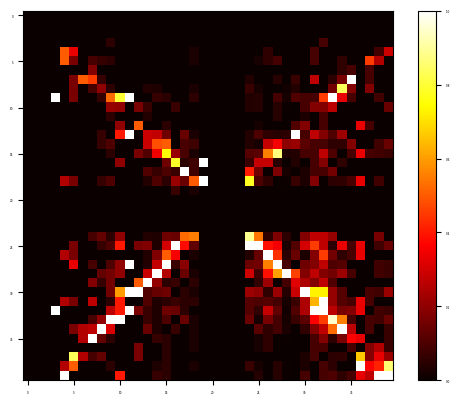

In [39]:
data = np.load('/data/HiHiC-main/data_hicplus/train_KR_300/train_ratio16.npz')

plt.imshow(data['target'][0,0], cmap='hot')
plt.colorbar()
plt.show()

True
18
(7809, 7809) 



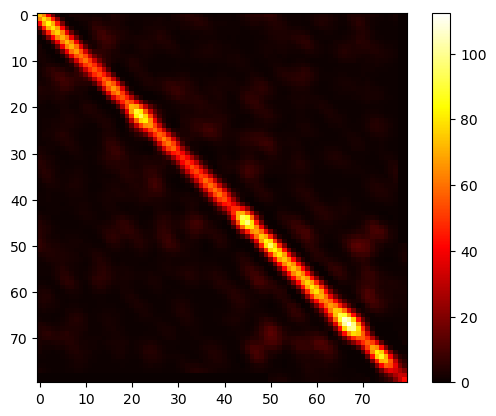

True
19
(5914, 5914) 



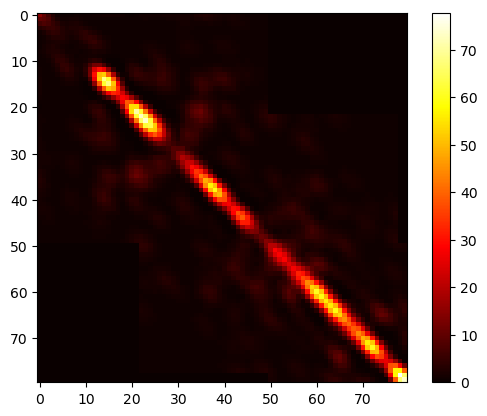

True
20
(6304, 6304) 



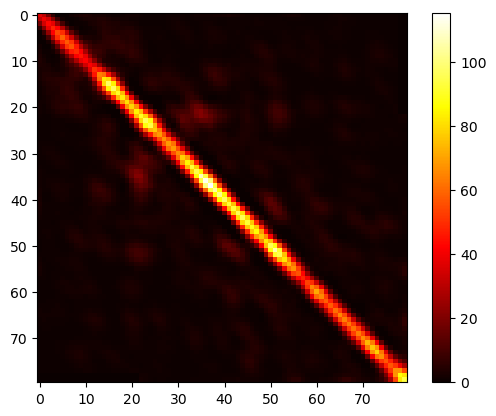

In [48]:
mat = np.load('/data/HiHiC-main/output_enhanced/hicplus_predict_16_00010.npz')
model = 'hicplus_00010'

if np.squeeze(mat['data']).shape[-1] == 40:
    make_whole_40('/data/HiHiC-main/output_enhanced/hicplus_predict_16_00010.npz', '/data/HiHiC-main/output_chrom/' + model + '.npz')    
else:      
    make_whole_28('/data/HiHiC-main/output_enhanced/hicplus_predict_16_00010.npz', '/data/HiHiC-main/output_chrom/' + model + '.npz')

file = np.load("/data/HiHiC-main/output_chrom/hicplus_00010.npz")
for chr in ['18','19','20']:
    print(np.allclose(file[chr], file[chr].T))
    print(chr)
    print(file[chr].shape, '\n')
    plt.imshow(file[chr][6:86, 6:86], cmap='hot')
    plt.colorbar()
    plt.show()

In [15]:
# 10000 train

os.makedirs('/data/HiHiC-main/output_chrom_hicplus/', exist_ok=True)
for out in os.listdir('/data/HiHiC-main/hicplus_10000'):
    mat = np.load('/data/HiHiC-main/hicplus_10000/' + out)
    model = out.split('.')[0].split('_')[3]
    
    if model == 'SRHiC':
        predicted = np.load('/data/HiHiC-main/output_enhanced/' + out, allow_pickle=True)
        index_file = os.path.join("/data/HiHiC-main/data_SRHiC/test_KR_300/index_test_ratio16.npz")
        index = np.load(index_file, allow_pickle=True)['inds_target']
        mats = {}
        unique_chrom = np.unique(index[:, 0])
        for chrom in sorted(unique_chrom):
            chrom_indices = index[:, 0] == chrom
            mat_dim = index[chrom_indices][0, 1] + 1
            inds = index[chrom_indices][:, -2:]
            submats = np.squeeze(predicted['data'])[chrom_indices, :, :]
            mat = np.zeros((mat_dim, mat_dim))
            for ind, submat in zip(inds, submats):
                mat[ind[0]:ind[0]+28, ind[1]:ind[1]+28] = submat
            mats[str(chrom)] = np.triu(mat) + np.triu(mat, k=1).T # mats[str(chrom)] = mat
        np.savez_compressed('/data/HiHiC-main/output_chrom/' + model + '.npz', **mats)
    
    elif np.squeeze(mat['data']).shape[-1] == 40:
        make_whole_40('/data/HiHiC-main/hicplus_10000/' + out, '/data/HiHiC-main/output_chrom_hicplus/' + model + '.npz')
        
    else:      
        make_whole_28('/data/HiHiC-main/hicplus_10000/' + out, '/data/HiHiC-main/output_chrom_hicplus/' + model + '.npz')

00100.npz
True
18
(7809, 7809) 



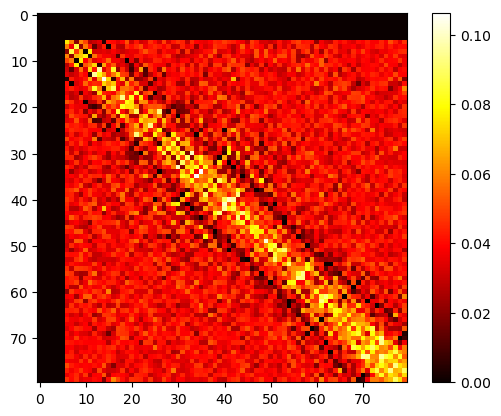

True
19
(5914, 5914) 



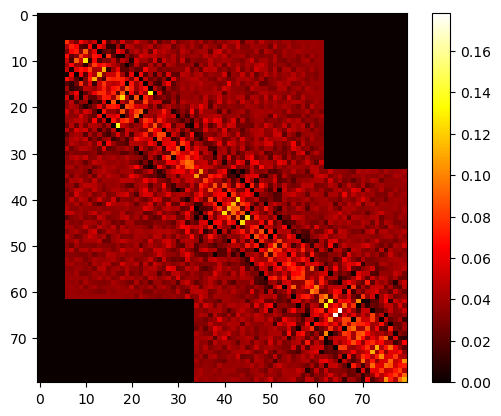

True
20
(6304, 6304) 



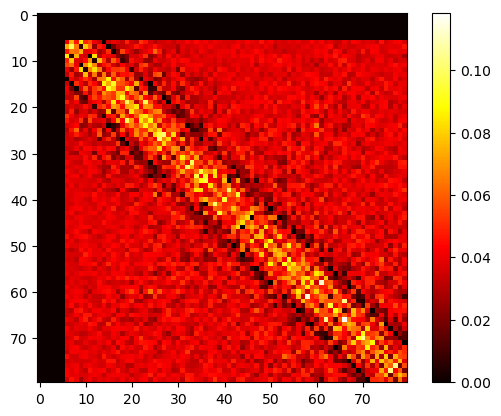

00300.npz
True
18
(7809, 7809) 



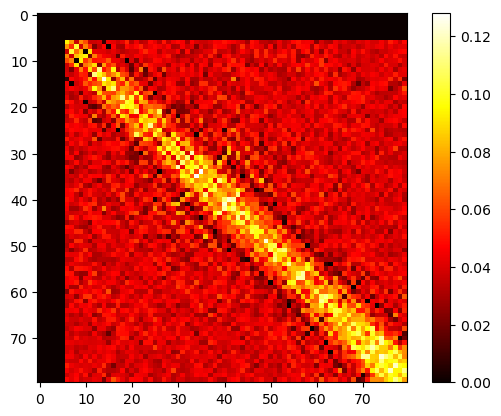

True
19
(5914, 5914) 



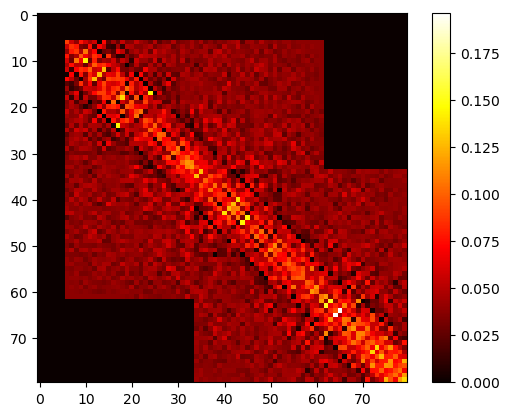

True
20
(6304, 6304) 



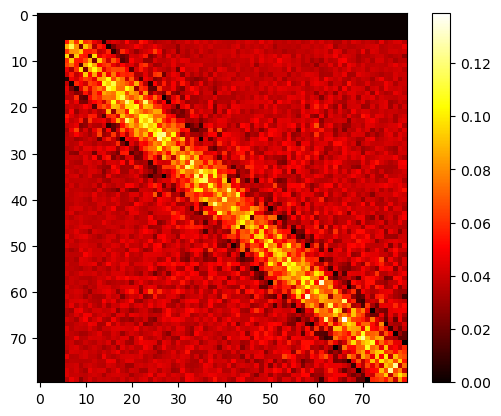

00500.npz
True
18
(7809, 7809) 



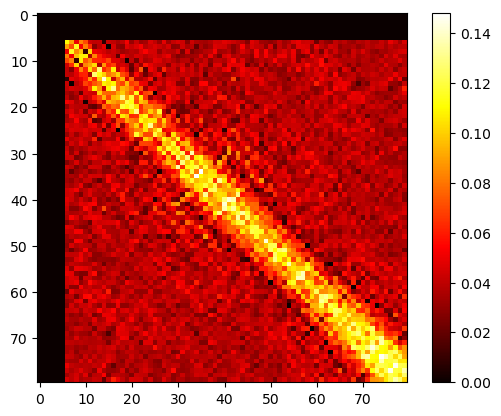

True
19
(5914, 5914) 



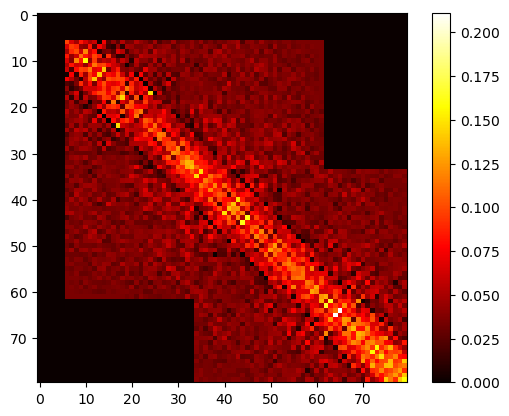

True
20
(6304, 6304) 



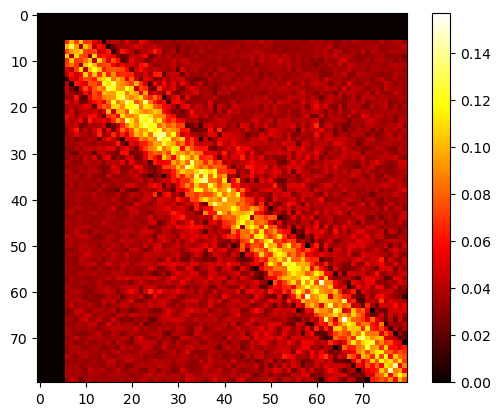

01000.npz
True
18
(7809, 7809) 



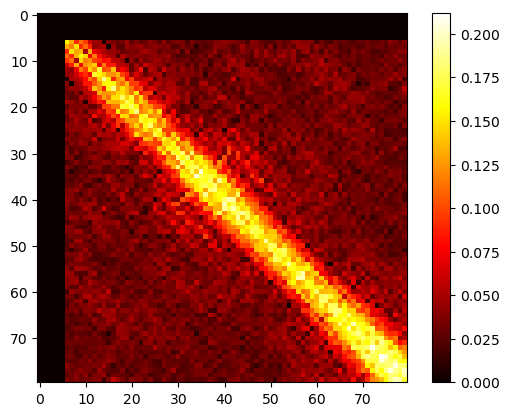

True
19
(5914, 5914) 



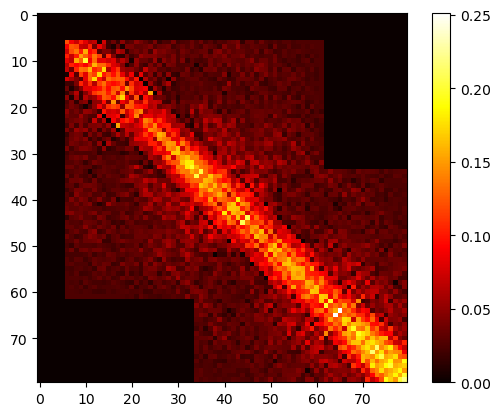

True
20
(6304, 6304) 



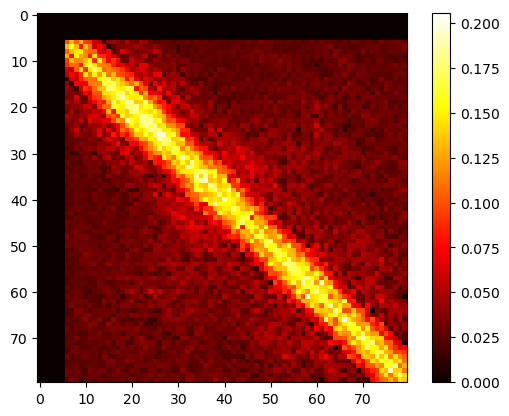

02000.npz
True
18
(7809, 7809) 



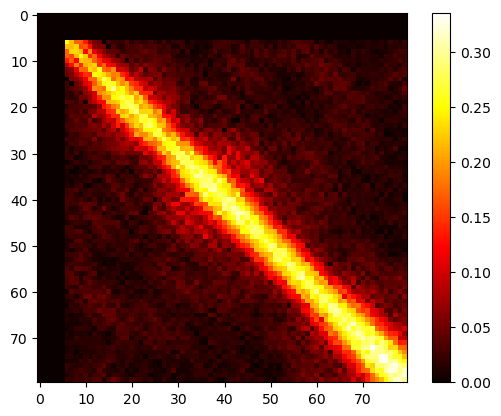

True
19
(5914, 5914) 



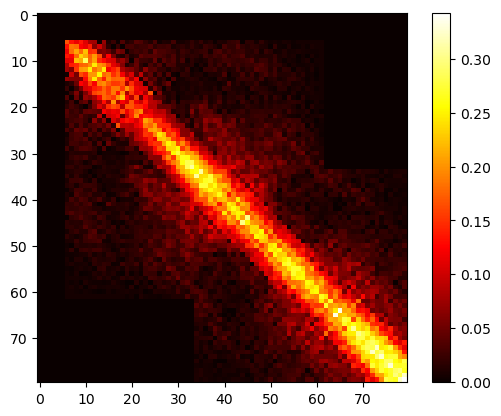

True
20
(6304, 6304) 



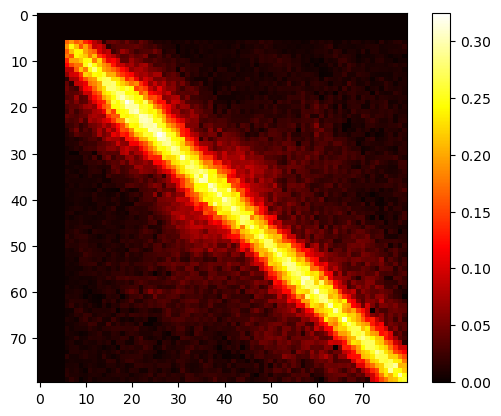

03000.npz
True
18
(7809, 7809) 



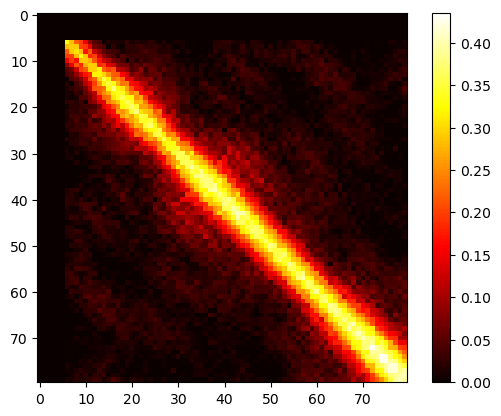

True
19
(5914, 5914) 



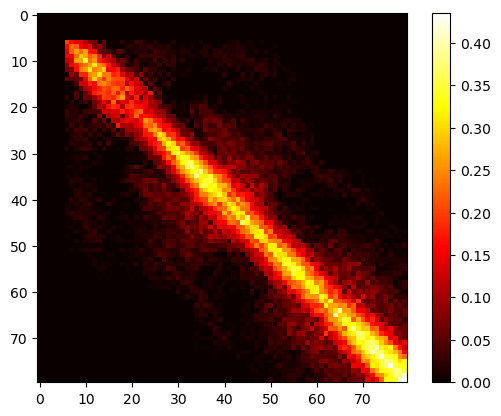

True
20
(6304, 6304) 



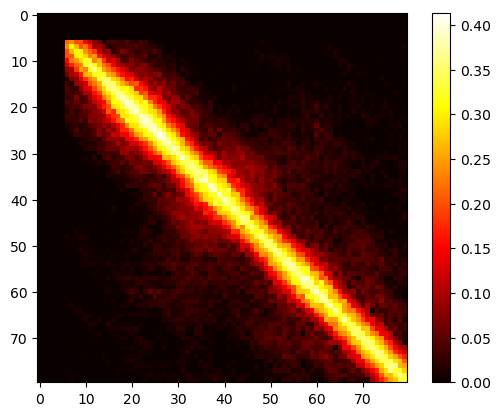

05000.npz
True
18
(7809, 7809) 



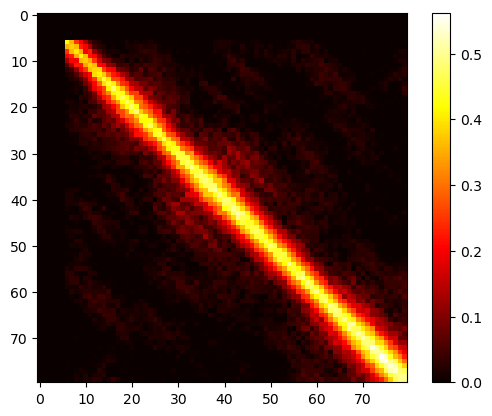

True
19
(5914, 5914) 



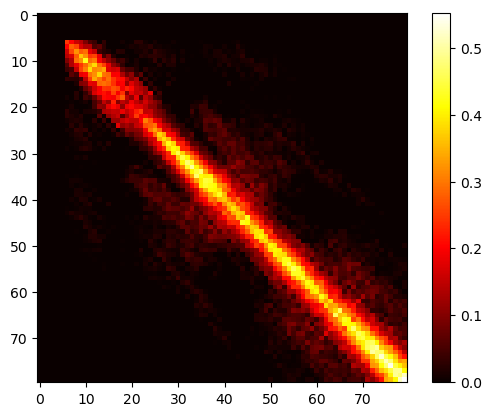

True
20
(6304, 6304) 



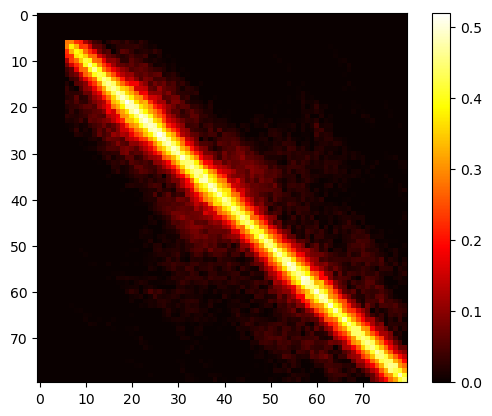

08000.npz
True
18
(7809, 7809) 



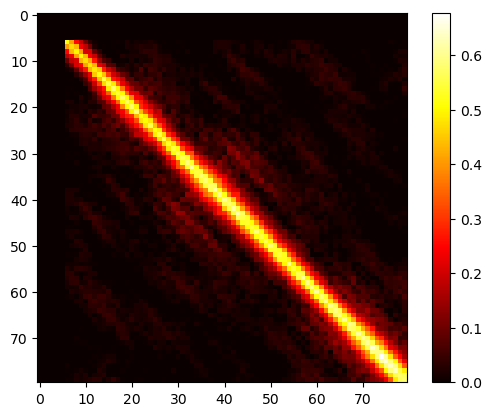

True
19
(5914, 5914) 



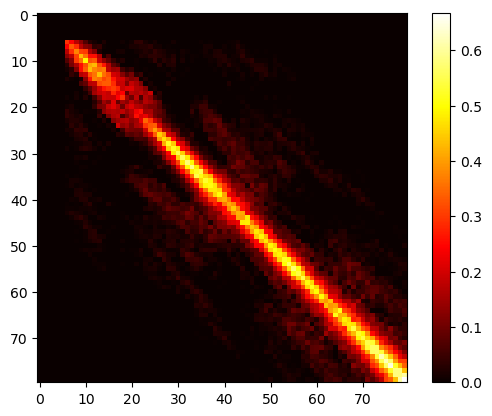

True
20
(6304, 6304) 



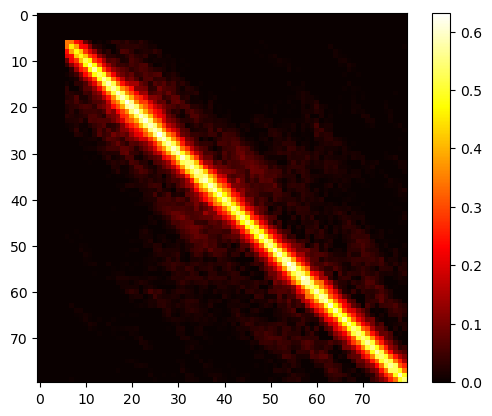

10000.npz
True
18
(7809, 7809) 



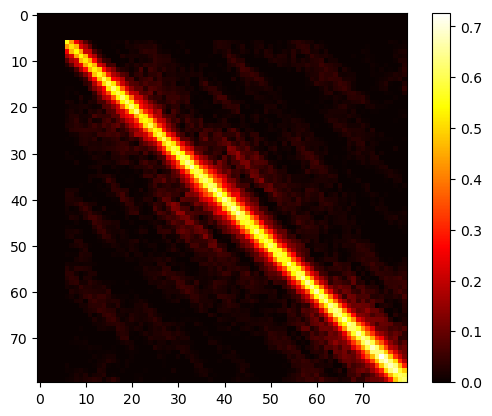

True
19
(5914, 5914) 



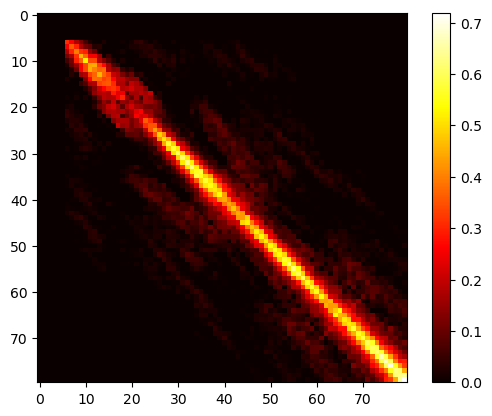

True
20
(6304, 6304) 



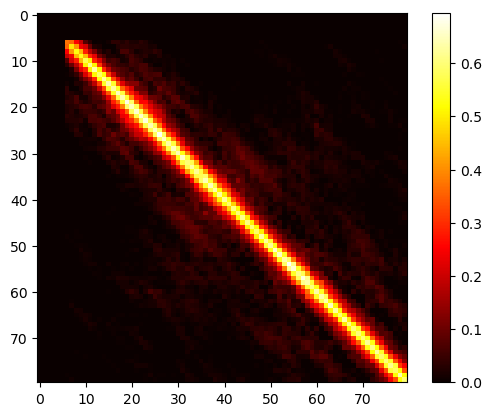

In [28]:
for out in sorted(os.listdir("/data/HiHiC-main/output_chrom_hicplus/")):
    print(out)
    file = np.load("/data/HiHiC-main/output_chrom_hicplus/"+out)
    for chr in ['18','19','20']:
        print(np.allclose(file[chr], file[chr].T))
        print(chr)
        print(file[chr].shape, '\n')
        plt.imshow(file[chr][0:80, 0:80], cmap='hot')
        plt.colorbar()
        plt.show()

In [30]:
# train data prediction

os.makedirs('/data/HiHiC-main/output_chrom_hicplus_prediction/', exist_ok=True)
for out in os.listdir('/data/HiHiC-main/hicplus_10000_train_prediction/'):
    mat = np.load('/data/HiHiC-main/hicplus_10000_train_prediction/' + out)
    model = out.split('.')[0].split('_')[3]
    
    if model == 'SRHiC':
        predicted = np.load('/data/HiHiC-main/output_enhanced/' + out, allow_pickle=True)
        index_file = os.path.join("/data/HiHiC-main/data_SRHiC/test_KR_300/index_test_ratio16.npz")
        index = np.load(index_file, allow_pickle=True)['inds_target']
        mats = {}
        unique_chrom = np.unique(index[:, 0])
        for chrom in sorted(unique_chrom):
            chrom_indices = index[:, 0] == chrom
            mat_dim = index[chrom_indices][0, 1] + 1
            inds = index[chrom_indices][:, -2:]
            submats = np.squeeze(predicted['data'])[chrom_indices, :, :]
            mat = np.zeros((mat_dim, mat_dim))
            for ind, submat in zip(inds, submats):
                mat[ind[0]:ind[0]+28, ind[1]:ind[1]+28] = submat
            mats[str(chrom)] = np.triu(mat) + np.triu(mat, k=1).T # mats[str(chrom)] = mat
        np.savez_compressed('/data/HiHiC-main/output_chrom/' + model + '.npz', **mats)
    
    elif np.squeeze(mat['data']).shape[-1] == 40:
        make_whole_40('/data/HiHiC-main/hicplus_10000_train_prediction/' + out, '/data/HiHiC-main/output_chrom_hicplus_prediction/' + model + '.npz')
        
    else:      
        make_whole_28('/data/HiHiC-main/hicplus_10000_train_prediction/' + out, '/data/HiHiC-main/output_chrom_hicplus_prediction/' + model + '.npz')

In [36]:
def make_whole_40(predicted, save_filename):
    predicted = np.load(predicted, allow_pickle=True)
    mats = {}
    unique_chrom = np.unique(predicted['inds'][:, 0])
    for chrom in sorted(unique_chrom):
        chrom_indices = predicted['inds'][:, 0] == chrom
        mat_dim = predicted['inds'][chrom_indices][0, 1] + 1
        inds = predicted['inds'][chrom_indices][:, -2:] + [6, 6]
        submats = np.squeeze(predicted['target'])[chrom_indices, 6:34, 6:34]    
        mat = np.zeros((mat_dim, mat_dim))
        for ind, submat in zip(inds, submats):
            mat[ind[0]:ind[0]+28, ind[1]:ind[1]+28] = submat
        mats[str(chrom)] = np.triu(mat) + np.triu(mat, k=1).T # mats[str(chrom)] = mat
    np.savez_compressed(save_filename, **mats)
    
    
def make_whole_28(predicted, save_filename):
    predicted = np.load(predicted, allow_pickle=True)
    mats = {}
    unique_chrom = np.unique(predicted['inds'][:, 0])
    for chrom in sorted(unique_chrom):
        chrom_indices = predicted['inds'][:, 0] == chrom
        mat_dim = predicted['inds'][chrom_indices][0, 1] + 1
        inds = predicted['inds'][chrom_indices][:, -2:]
        submats = np.squeeze(predicted['target'])[chrom_indices, :, :]
        mat = np.zeros((mat_dim, mat_dim))
        for ind, submat in zip(inds, submats):
            mat[ind[0]:ind[0]+28, ind[1]:ind[1]+28] = submat
        mats[str(chrom)] = np.triu(mat) + np.triu(mat, k=1).T # mats[str(chrom)] = mat
    np.savez_compressed(save_filename, **mats)

mat = np.load('/data/HiHiC-main/data_hicplus/train_KR_300/train_ratio16.npz', allow_pickle=True)
mat['target'].shape

if np.squeeze(mat['target']).shape[-1] == 40:
    make_whole_40('/data/HiHiC-main/data_hicplus/train_KR_300/train_ratio16.npz', '/data/HiHiC-main/output_chrom_hicplus_prediction/train_target.npz')
    
else:      
    make_whole_28('/data/HiHiC-main/data_hicplus/train_KR_300/train_ratio16.npz', '/data/HiHiC-main/output_chrom_hicplus_prediction/train_target.npz')

00100.npz
True
1
(24927, 24927) 



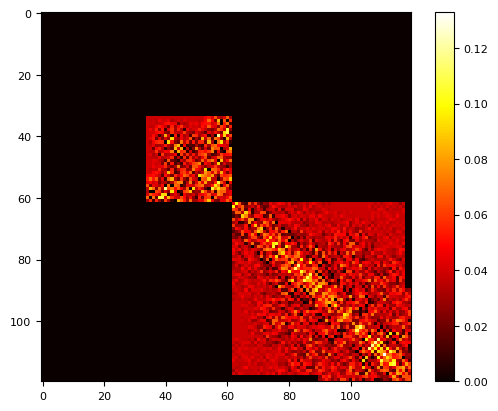

00300.npz
True
1
(24927, 24927) 



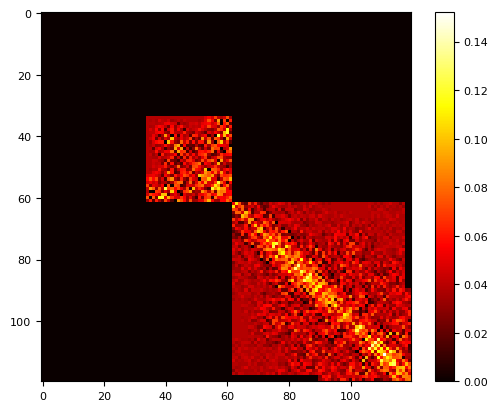

00500.npz
True
1
(24927, 24927) 



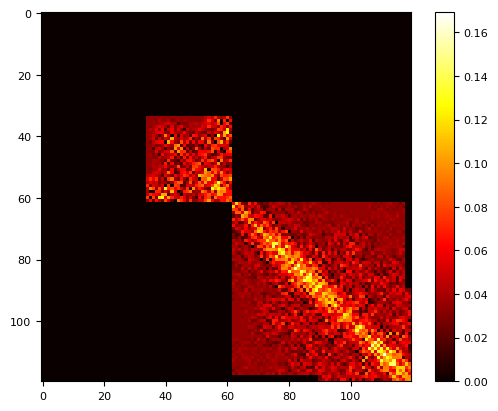

01000.npz
True
1
(24927, 24927) 



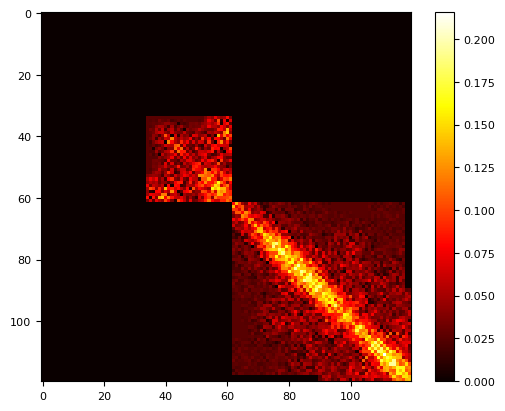

02000.npz
True
1
(24927, 24927) 



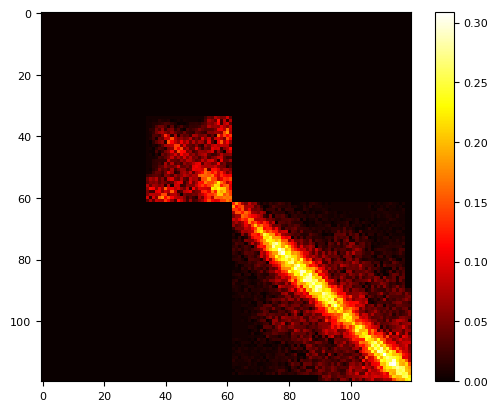

03000.npz
True
1
(24927, 24927) 



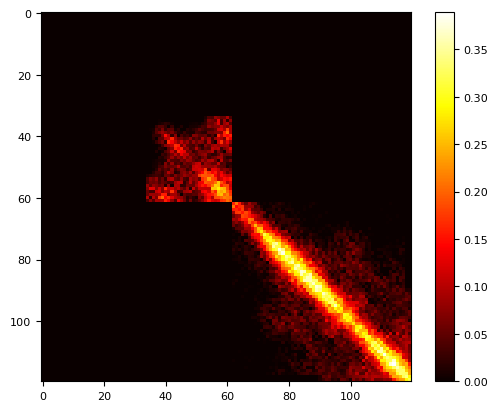

05000.npz
True
1
(24927, 24927) 



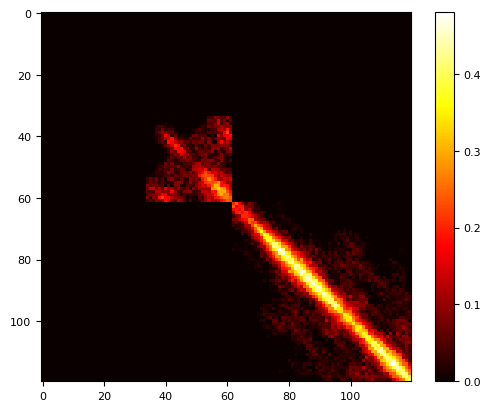

08000.npz
True
1
(24927, 24927) 



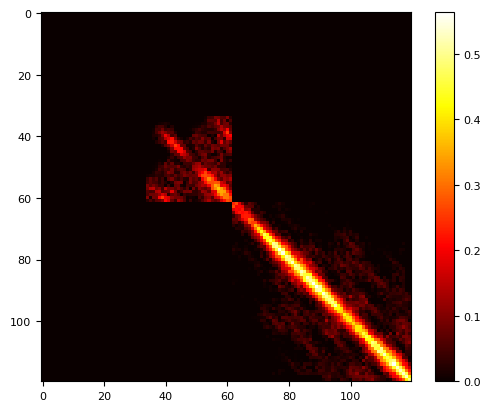

10000.npz
True
1
(24927, 24927) 



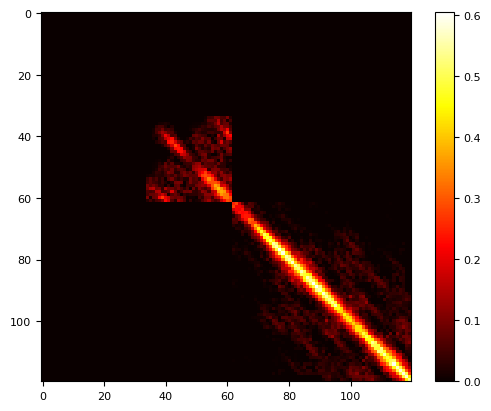

train_data.npz
True
1
(24927, 24927) 



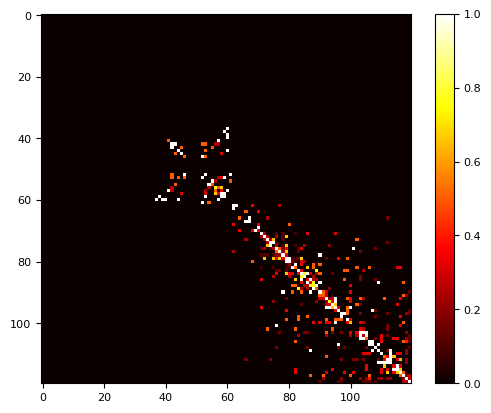

train_target.npz
True
1
(24927, 24927) 



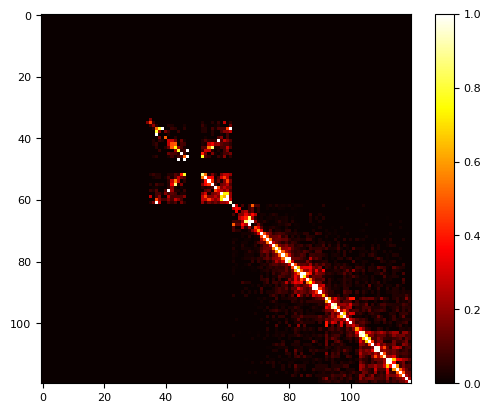

In [38]:
plt.rcParams.update({'font.size': 8})

for out in sorted(os.listdir("/data/HiHiC-main/output_chrom_hicplus_prediction/")):
    print(out)
    file = np.load("/data/HiHiC-main/output_chrom_hicplus_prediction/"+out)
    for chr in ['1']:
        print(np.allclose(file[chr], file[chr].T))
        print(chr)
        print(file[chr].shape, '\n')
        plt.imshow(file[chr][0:120, 0:120], cmap='hot')
        plt.colorbar()
        plt.show()

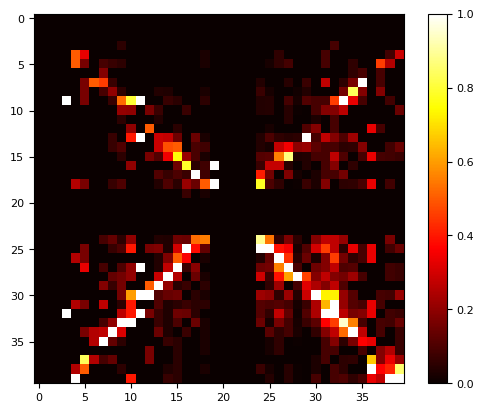

In [44]:
m = np.load("/data/HiHiC-main/data_hicplus/train_KR_300/train_ratio16.npz")['target'][0,0]
plt.imshow(m, cmap='hot')
plt.colorbar()
plt.show()

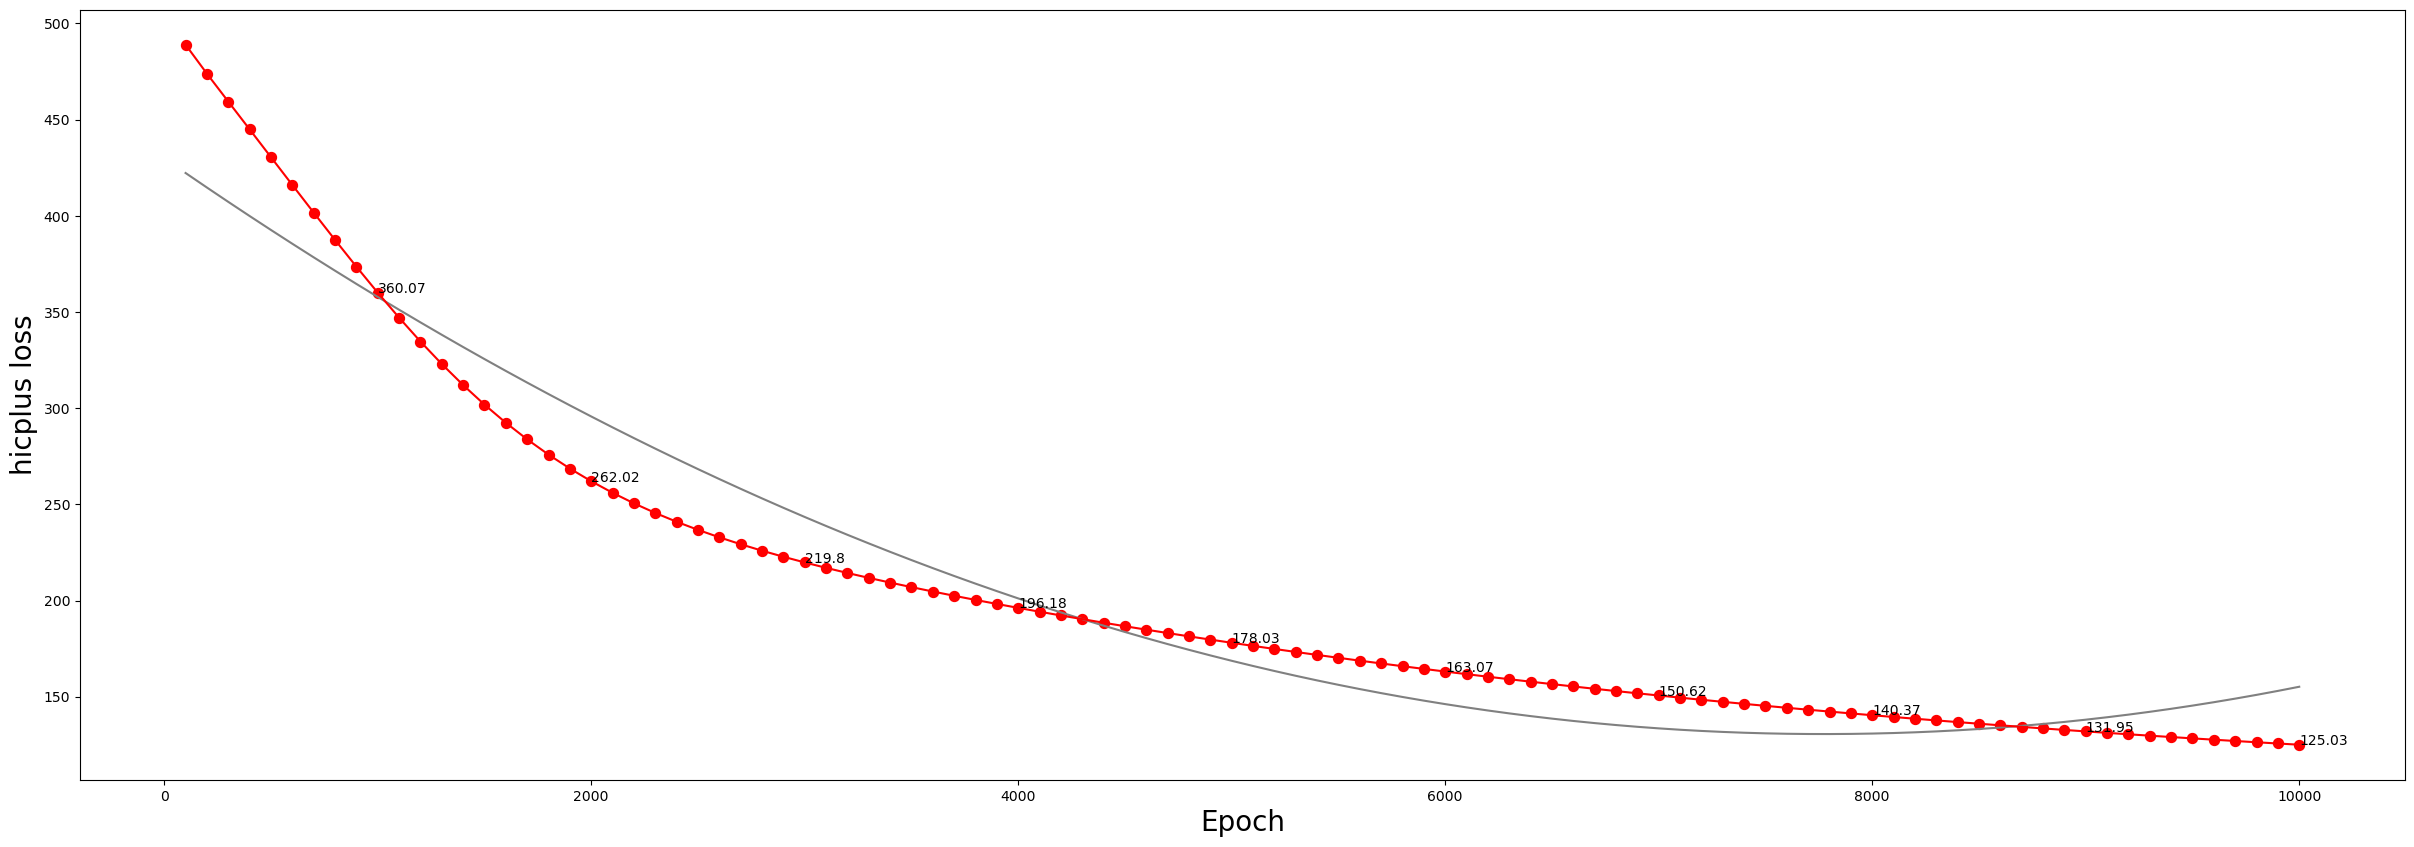

In [28]:
plt.rcParams.update({'font.size': 10})

# i = 'train_loss_hicplus.npy'
c = 'red'

model='hicplus'
plt.figure(figsize=(30,10))
i = np.load("/data/HiHiC-main/hicplus_10000_train_prediction/predict_loss_hicplus.npy", allow_pickle=True)
x = list(map(int, i[0]))
y = list(map(float, i[1]))
plt.scatter(x,y, s=10, c=c, linewidths=5)
z = np.polyfit(x,y, 2)
p = np.poly1d(z)
plt.plot(x, p(x), color='gray')
plt.plot(x, y, color=c, label=model)
for i, (xx, yy) in enumerate(zip(x, y)):
    if xx%1000 ==0:
        plt.text(xx, yy, round(yy, 2))
# plt.ylim([0.39, 0.42]) # [0.39, 0.42]
plt.xlabel("Epoch", fontsize="20")
plt.ylabel(model+" loss", fontsize="20")
# plt.legend(fontsize="20")
# plt.savefig('loss_trend.png')
plt.show()

In [31]:
np.load("/data/HiHiC-main/hicplus_10000_train_prediction/predict_loss_hicplus.npy", allow_pickle=True)

array([list(['00100', '00200', '00300', '00400', '00500', '00600', '00700', '00800', '00900', '01000', '01100', '01200', '01300', '01400', '01500', '01600', '01700', '01800', '01900', '02000', '02100', '02200', '02300', '02400', '02500', '02600', '02700', '02800', '02900', '03000', '03100', '03200', '03300', '03400', '03500', '03600', '03700', '03800', '03900', '04000', '04100', '04200', '04300', '04400', '04500', '04600', '04700', '04800', '04900', '05000', '05100', '05200', '05300', '05400', '05500', '05600', '05700', '05800', '05900', '06000', '06100', '06200', '06300', '06400', '06500', '06600', '06700', '06800', '06900', '07000', '07100', '07200', '07300', '07400', '07500', '07600', '07700', '07800', '07900', '08000', '08100', '08200', '08300', '08400', '08500', '08600', '08700', '08800', '08900', '09000', '09100', '09200', '09300', '09400', '09500', '09600', '09700', '09800', '09900', '10000']),
       list([488.9586870764033, 473.9078951081028, 459.408950621495, 444.952557082579

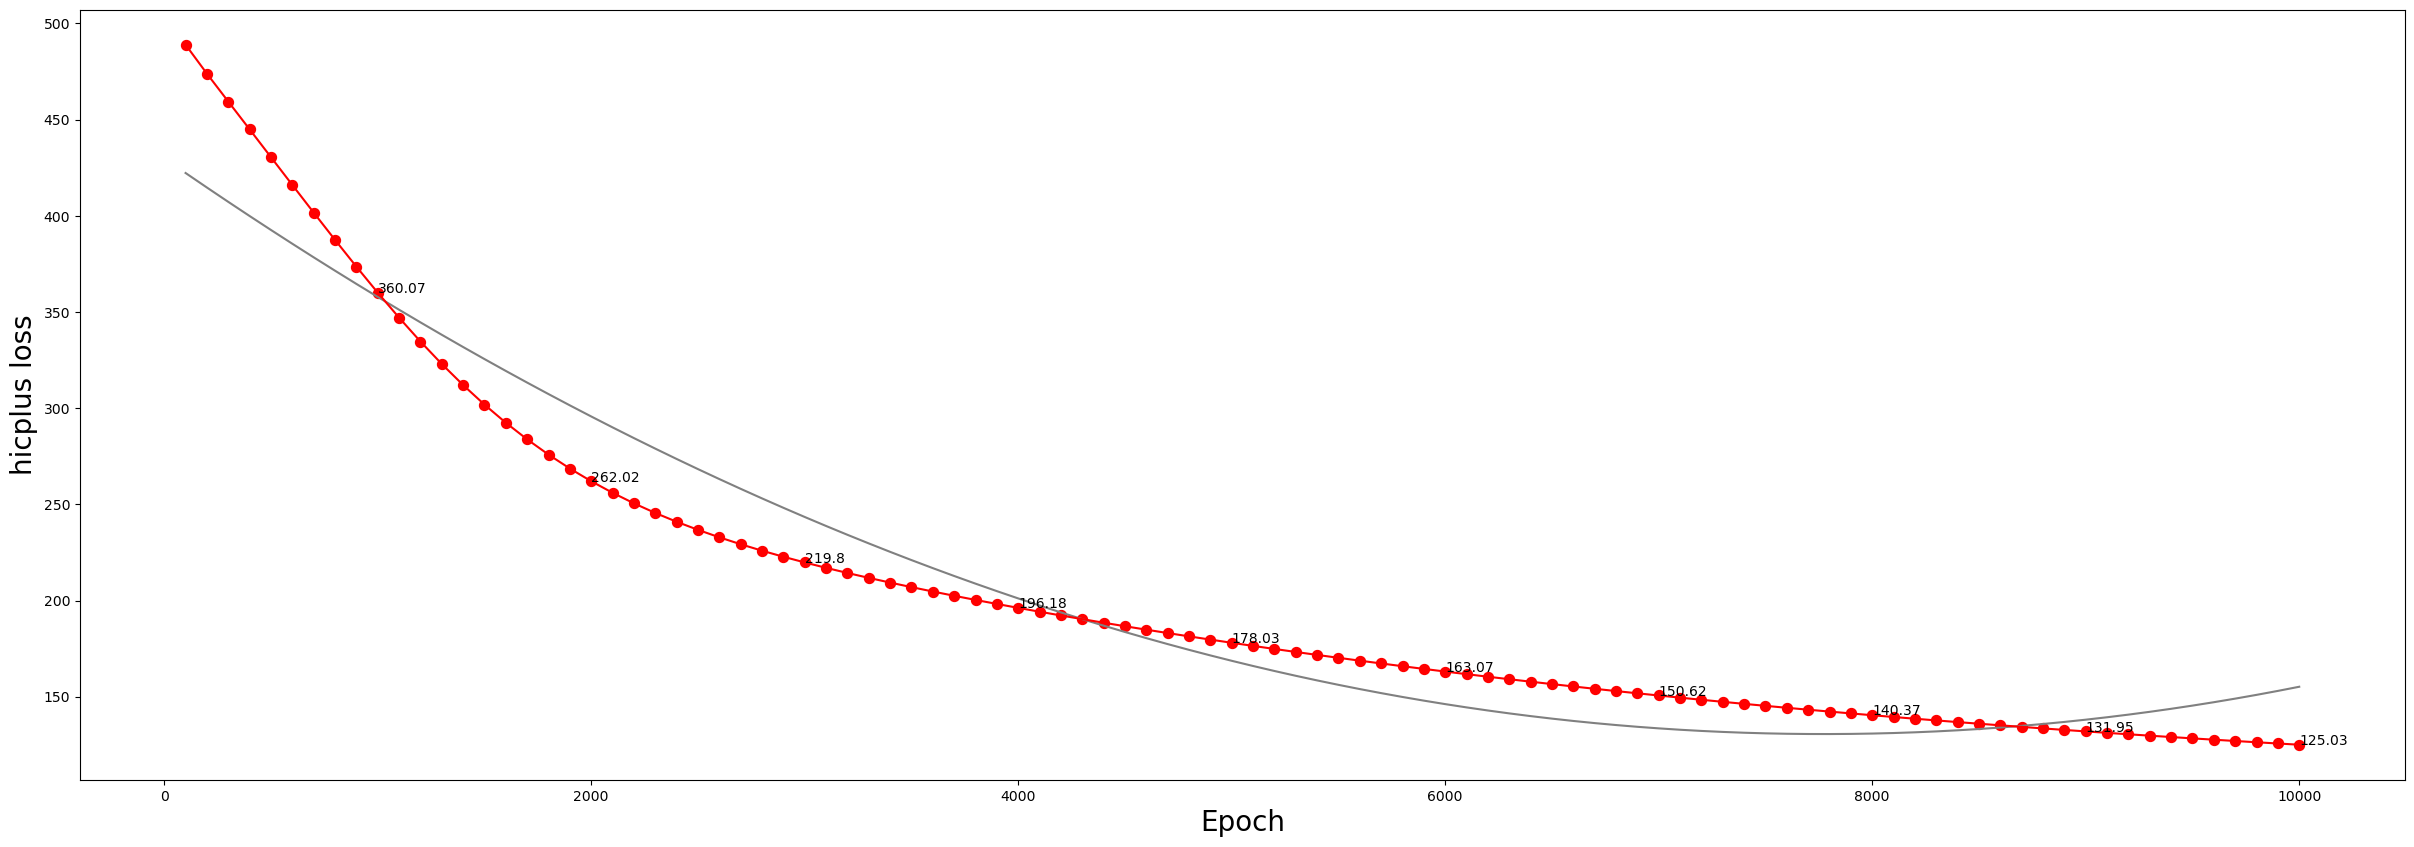

In [32]:
plt.rcParams.update({'font.size': 10})

# i = 'train_loss_hicplus.npy'
c = 'red'

model='hicplus'
plt.figure(figsize=(30,10))
i = np.load("/data/HiHiC-main/hicplus_10000_train_prediction/predict_loss_hicplus.npy", allow_pickle=True)
x = list(map(int, i[0]))
y = list(map(float, i[1]))
plt.scatter(x,y, s=10, c=c, linewidths=5)
z = np.polyfit(x,y, 2)
p = np.poly1d(z)
plt.plot(x, p(x), color='gray')
plt.plot(x, y, color=c, label=model)
for i, (xx, yy) in enumerate(zip(x, y)):
    if xx%1000 ==0:
        plt.text(xx, yy, round(yy, 2))
# plt.ylim([0.39, 0.42]) # [0.39, 0.42]
plt.xlabel("Epoch", fontsize="20")
plt.ylabel(model+" loss", fontsize="20")
# plt.legend(fontsize="20")
# plt.savefig('loss_trend.png')
plt.show()